In [1]:
import os, sys, json
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

In [2]:
from datetime import datetime

DEVICE_NAME = 'cuda:1'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
MODEL_NAME = f'detector_{now}'
MODEL_NAME

'detector_2020-06-08--23-17-22'

In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
PALETTE = sns.color_palette('pastel')

In [5]:
data_path = '../data/'
preproc_val_file = os.path.join(data_path, 'preproc_val.json')
preproc_train_file = os.path.join(data_path, 'preproc_train.json')
preproc_deduplicated_train_file = os.path.join(data_path, 'preproc_deduplicated_train.json')

In [6]:
with open(preproc_val_file) as rf:
    preproc_val = json.load(rf)
len(preproc_val)

1000

In [7]:
with open(preproc_train_file) as rf:
    preproc_train = json.load(rf)
len(preproc_train)

24632

In [8]:
with open(preproc_deduplicated_train_file) as rf:
    preproc_deduplicated_train = json.load(rf)
len(preproc_deduplicated_train)

21800

In [9]:
def show_sample(sample):
    fig = plt.figure(figsize=(14,10))
    fname = os.path.join(data_path, sample['file'])
    boxes = sample['boxes']
    coords = sample['coords']
    texts = sample['texts']
    print(f'File: {fname}')
    print(f'Bboxes count: {len(boxes)}')
    print(f'Coordinates: {coords}')
    print(f'Numbers: {texts}')
    img = cv2.imread(fname)
    for box in boxes:
        x1, y1, x2, y2 = box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), np.array(PALETTE[0]) * 255, 2)
        cv2.drawContours(img, np.array(coords)[None,...], 0, np.array(PALETTE[1]) * 255, 2)
    plt.imshow(img[...,::-1])

File: ../data/train/15.bmp
Bboxes count: 1
Coordinates: [[[13, 174], [129, 185], [133, 215], [11, 203]]]
Numbers: ['E646AA35']


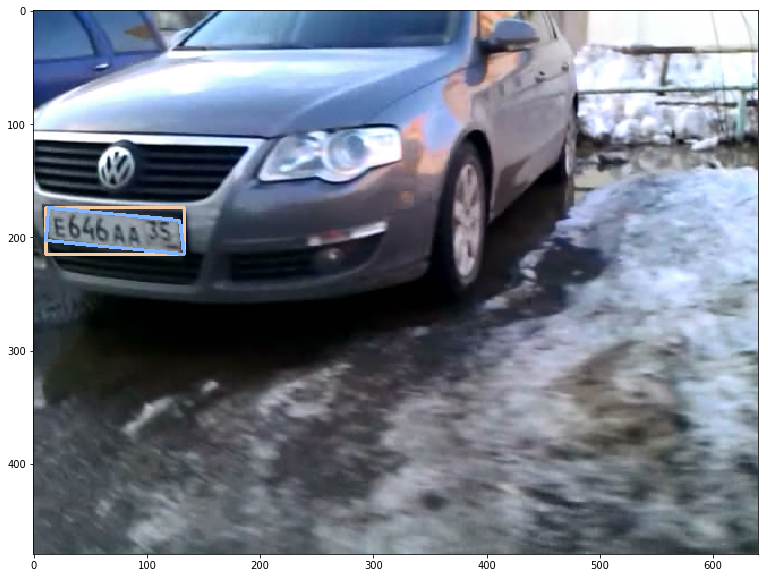

In [10]:
show_sample(preproc_val[0])

In [11]:
from PIL import Image, ImageDraw
from itertools import chain

def make_mask(img, box):
    h, w, _ = img.shape
    
    mask = Image.new('L', (w, h), 0)
    ImageDraw.Draw(mask).polygon(list(chain(*box)), outline=1, fill=1)
    mask = np.array(mask)
    return mask

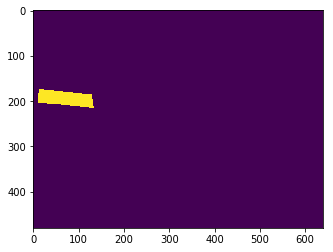

In [12]:
idx = 0
sample = preproc_val[idx]
fname = os.path.join(data_path, sample['file'])
img = cv2.imread(fname)

mask = make_mask(img, sample['coords'][0])
plt.imshow(mask)

In [13]:
class DetectionDataset(Dataset):
    def __init__(self, data, data_path=data_path, transforms=None):
        
        self.data = data
        self.data_path = data_path
        self.transforms = transforms
        
    def __getitem__(self, idx):
        sample = self.data[idx]
        fname = os.path.join(self.data_path, sample['file'])
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
            
        boxes = torch.as_tensor(sample['boxes'])
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        masks = torch.as_tensor([make_mask(img, coords) for coords in sample['coords']])
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    def get_height_and_width(self, idx):
        sample = self.data[idx]
        return sample['height'], sample['width']
    
    def __len__(self):
        return len(self.data)

In [14]:
train_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [15]:
train_dataset = DetectionDataset(
    data=preproc_train, 
    transforms=train_transforms
)

val_dataset = DetectionDataset(
    data=preproc_val, 
    transforms=train_transforms
)

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
BATCH_SIZE = 2
NUM_WORKERS = 4
HID_DIM = 256

In [18]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn, 
)

In [19]:
def get_detector_model(mask_hid_size, num_classes=2):    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        progress=True,
        trainable_backbone_layers=4
    )

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    mask_predictor = MaskRCNNPredictor(in_features_mask, mask_hid_size, num_classes)
    model.roi_heads.mask_predictor = mask_predictor
    
#     for param in model.parameters():
#         param.requires_grad = False
        
#     for param in model.backbone.fpn.parameters():
#         param.requires_grad = True

#     for param in model.rpn.parameters():
#         param.requires_grad = True

#     for param in model.roi_heads.parameters():
#         param.requires_grad = True
    
    return model

In [20]:
def get_iou(bb1, bb2):
    # https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    b1x1, b1y1, b1x2, b1y2 = bb1
    b2x1, b2y1, b2x2, b2y2 = bb2
    
    assert b1x1 < b1x2
    assert b1y1 < b1y2
    assert b2x1 < b2x2
    assert b2y1 < b2y2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1x1, b2x1)
    y_top = max(b1y1, b2y1)
    x_right = min(b1x2, b2x2)
    y_bottom = min(b1y2, b2y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (b1x2 - b1x1) * (b1y2 - b1y1)
    bb2_area = (b2x2 - b2x1) * (b2y2 - b2y1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [21]:
def get_mean_jaccard(target_boxes, prediction, threshold=0.5):
    # target_boxes уже отсортированы по возрастанию минимальной x-координаты
    target_boxes = target_boxes.cpu().numpy()
    pred_boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    pred_boxes = [box for (box, score) in zip(pred_boxes, scores) if score >= threshold]
    pred_boxes = sorted(pred_boxes, key=lambda x: x[0])
    mean_jaccard = 0
    for target_box, pred_box in zip(target_boxes, pred_boxes):
        mean_jaccard += get_iou(target_box, pred_box)
    mean_jaccard /= max(len(target_boxes), len(pred_boxes))
    return mean_jaccard

In [22]:
@torch.no_grad()
def evaluate_iou(model, iterator, threshold, take_first=None, with_tqdm=True):    
    model.eval()
    total_batches = take_first or len(iterator)
    ious = []
    if with_tqdm:
        iterator = tqdm(iterator, total=total_batches, leave=True, position=0, desc='batch')
    for i, batch in enumerate(iterator):
        if i >= total_batches:
            break
        images, targets = batch
        images = [image.to(device) for image in images]
        predictions = model(images)
        for target, pred in zip(targets, predictions):
            iou = get_mean_jaccard(target['boxes'], pred, threshold)
            ious.append(iou)
    ious = np.array(ious)        
    return ious.mean(), ious

In [23]:
def train(model, train_iterator, val_iterator, optimizer, scheduler=None, epochs=7, iou_threshold=0.9):
    model.train()
    running_loss = []
    best_val_iou = -1
    for epoch in range(epochs):
        print(f'Epoch {epoch} started')
        for i, batch in tqdm(enumerate(train_iterator), total=len(train_iterator), leave=False, position=0, desc='batch'):
            images, targets = batch
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = model(images, targets)
            losses = sum(loss_dict.values())

            losses.backward()
            optimizer.step()

            running_loss.append(losses.item())

            if (i + 1) % 100 == 0:
                mean_loss = np.mean(running_loss)
                print(f'Train batch loss: {mean_loss}')
                if scheduler is not None:
                    scheduler.step(mean_loss)
                running_loss = []

            if (i + 1) % 1000 == 0:
                val_iou, _ = evaluate_iou(model, val_iterator, iou_threshold, take_first=None, with_tqdm=False)
                model.train()
                print(f'Val IoU@{iou_threshold}: {val_iou}')
                if val_iou >= best_val_iou:
                    best_val_iou = val_iou
                    print(f'New best val IoU@{iou_threshold}: {val_iou}')
                    with open(f'models/{MODEL_NAME}.pth', 'wb') as fp:
                        torch.save(model.state_dict(), fp)

In [24]:
device = torch.device(DEVICE_NAME) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=1)

In [25]:
model = get_detector_model(HID_DIM)
model.to(device);

In [26]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=3e-4, weight_decay=0.01, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [27]:
warnings.filterwarnings("ignore", message="The default behavior for")
warnings.filterwarnings("ignore", message="This overload of nonzero")

In [28]:
train(model, train_loader, val_loader, optimizer)

Epoch 0 started


batch:   1%|          | 100/12316 [00:53<1:36:57,  2.10it/s]

Train batch loss: 0.44921889632940293


batch:   2%|▏         | 200/12316 [01:43<1:38:14,  2.06it/s]

Train batch loss: 0.24918451249599458


batch:   2%|▏         | 300/12316 [02:32<1:42:00,  1.96it/s]

Train batch loss: 0.23067071929574012


batch:   3%|▎         | 400/12316 [03:22<1:37:26,  2.04it/s]

Train batch loss: 0.23636510893702506


batch:   4%|▍         | 500/12316 [04:13<1:36:55,  2.03it/s]

Train batch loss: 0.24848336815834046


batch:   5%|▍         | 600/12316 [05:04<1:36:54,  2.02it/s]

Train batch loss: 0.22165725633502006


batch:   6%|▌         | 700/12316 [05:54<1:38:20,  1.97it/s]

Train batch loss: 0.205598284304142


batch:   6%|▋         | 800/12316 [06:44<1:38:06,  1.96it/s]

Train batch loss: 0.18999381259083747


batch:   7%|▋         | 900/12316 [07:35<1:37:48,  1.95it/s]

Train batch loss: 0.19277716740965845


batch:   8%|▊         | 999/12316 [08:25<1:40:28,  1.88it/s]

Train batch loss: 0.18538436122238636
Val IoU@0.9: 0.7883698977261886
New best val IoU@0.9: 0.7883698977261886


batch:   9%|▉         | 1100/12316 [10:50<1:36:18,  1.94it/s] 

Train batch loss: 0.1937802416831255


batch:  10%|▉         | 1200/12316 [11:40<1:38:14,  1.89it/s]

Train batch loss: 0.2089366029947996


batch:  11%|█         | 1300/12316 [12:30<1:32:08,  1.99it/s]

Train batch loss: 0.17807849153876304


batch:  11%|█▏        | 1400/12316 [13:20<1:36:25,  1.89it/s]

Train batch loss: 0.19452209278941154


batch:  12%|█▏        | 1500/12316 [14:11<1:29:45,  2.01it/s]

Train batch loss: 0.20857844479382037


batch:  13%|█▎        | 1600/12316 [15:02<1:35:12,  1.88it/s]

Train batch loss: 0.2152595117688179


batch:  14%|█▍        | 1700/12316 [15:53<1:27:48,  2.02it/s]

Train batch loss: 0.1849979382008314


batch:  15%|█▍        | 1800/12316 [16:44<1:28:21,  1.98it/s]

Train batch loss: 0.18394406393170357


batch:  15%|█▌        | 1900/12316 [17:35<1:28:02,  1.97it/s]

Train batch loss: 0.17100057817995548


batch:  16%|█▌        | 1999/12316 [18:25<1:25:12,  2.02it/s]

Train batch loss: 0.18946091793477535


batch:  16%|█▌        | 2000/12316 [20:00<82:31:23, 28.80s/it]

Val IoU@0.9: 0.7552395841887056


batch:  17%|█▋        | 2100/12316 [20:51<1:22:22,  2.07it/s] 

Train batch loss: 0.17798234917223454


batch:  18%|█▊        | 2200/12316 [21:41<1:26:29,  1.95it/s]

Train batch loss: 0.19049191616475583


batch:  19%|█▊        | 2300/12316 [22:32<1:24:26,  1.98it/s]

Train batch loss: 0.197297368273139


batch:  19%|█▉        | 2400/12316 [23:23<1:20:09,  2.06it/s]

Train batch loss: 0.17610982932150365


batch:  20%|██        | 2500/12316 [24:13<1:28:28,  1.85it/s]

Train batch loss: 0.1870567710697651


batch:  21%|██        | 2600/12316 [25:03<1:18:01,  2.08it/s]

Train batch loss: 0.21354687564074992


batch:  22%|██▏       | 2700/12316 [25:53<1:18:52,  2.03it/s]

Train batch loss: 0.1634867575764656


batch:  23%|██▎       | 2800/12316 [26:43<1:20:52,  1.96it/s]

Train batch loss: 0.18957885645329953


batch:  24%|██▎       | 2900/12316 [27:34<1:16:04,  2.06it/s]

Train batch loss: 0.17885512351989746


batch:  24%|██▍       | 2999/12316 [28:24<1:19:16,  1.96it/s]

Train batch loss: 0.1765479328483343
Val IoU@0.9: 0.8265740926125515
New best val IoU@0.9: 0.8265740926125515


batch:  25%|██▌       | 3100/12316 [30:46<1:16:31,  2.01it/s] 

Train batch loss: 0.1747275183349848


batch:  26%|██▌       | 3200/12316 [31:37<1:16:09,  1.99it/s]

Train batch loss: 0.16469562277197838


batch:  27%|██▋       | 3300/12316 [32:28<1:15:15,  2.00it/s]

Train batch loss: 0.17201908454298973


batch:  28%|██▊       | 3400/12316 [33:19<1:15:08,  1.98it/s]

Train batch loss: 0.16224172823131083


batch:  28%|██▊       | 3500/12316 [34:09<1:11:34,  2.05it/s]

Train batch loss: 0.18026886403560638


batch:  29%|██▉       | 3600/12316 [35:00<1:12:56,  1.99it/s]

Train batch loss: 0.16809783332049846


batch:  30%|███       | 3700/12316 [35:50<1:15:05,  1.91it/s]

Train batch loss: 0.17667015731334687


batch:  31%|███       | 3800/12316 [36:42<1:12:46,  1.95it/s]

Train batch loss: 0.18085718236863613


batch:  32%|███▏      | 3900/12316 [37:33<1:14:52,  1.87it/s]

Train batch loss: 0.17200639210641383


batch:  32%|███▏      | 3999/12316 [38:22<1:11:32,  1.94it/s]

Train batch loss: 0.1787868820875883
Val IoU@0.9: 0.8300698748273686
New best val IoU@0.9: 0.8300698748273686


batch:  33%|███▎      | 4100/12316 [40:43<1:12:20,  1.89it/s] 

Train batch loss: 0.1679470466822386


batch:  34%|███▍      | 4200/12316 [41:34<1:07:19,  2.01it/s]

Train batch loss: 0.1681658761948347


batch:  35%|███▍      | 4300/12316 [42:25<1:08:57,  1.94it/s]

Train batch loss: 0.1752495338767767


batch:  36%|███▌      | 4400/12316 [43:16<1:10:32,  1.87it/s]

Train batch loss: 0.17343399055302144


batch:  37%|███▋      | 4500/12316 [44:06<1:05:52,  1.98it/s]

Train batch loss: 0.18105900950729847


batch:  37%|███▋      | 4600/12316 [44:57<1:10:57,  1.81it/s]

Train batch loss: 0.17186417654156685


batch:  38%|███▊      | 4700/12316 [45:47<1:05:14,  1.95it/s]

Train batch loss: 0.16422960937023162


batch:  39%|███▉      | 4800/12316 [46:38<1:05:43,  1.91it/s]

Train batch loss: 0.16425812177360058


batch:  40%|███▉      | 4900/12316 [47:29<1:02:07,  1.99it/s]

Train batch loss: 0.1613096495717764


batch:  41%|████      | 4999/12316 [48:20<1:00:02,  2.03it/s]

Train batch loss: 0.16076612211763858
Val IoU@0.9: 0.8391203095038522
New best val IoU@0.9: 0.8391203095038522


batch:  41%|████▏     | 5100/12316 [50:42<59:19,  2.03it/s]   

Train batch loss: 0.17824876338243484


batch:  42%|████▏     | 5200/12316 [51:32<58:40,  2.02it/s]  

Train batch loss: 0.1756305703520775


batch:  43%|████▎     | 5300/12316 [52:22<57:00,  2.05it/s]  

Train batch loss: 0.1708632230013609


batch:  44%|████▍     | 5400/12316 [53:13<59:18,  1.94it/s]  

Train batch loss: 0.16589976504445075


batch:  45%|████▍     | 5500/12316 [54:04<58:37,  1.94it/s]  

Train batch loss: 0.16782428108155728


batch:  45%|████▌     | 5600/12316 [54:55<54:08,  2.07it/s]  

Train batch loss: 0.16250336572527885


batch:  46%|████▋     | 5700/12316 [55:46<56:39,  1.95it/s]  

Train batch loss: 0.17884330257773398


batch:  47%|████▋     | 5800/12316 [56:38<56:35,  1.92it/s]  

Train batch loss: 0.1769835390150547


batch:  48%|████▊     | 5900/12316 [57:28<55:32,  1.93it/s]  

Train batch loss: 0.17166375368833542


batch:  49%|████▊     | 5999/12316 [58:18<53:01,  1.99it/s]  

Train batch loss: 0.1627964061498642
Val IoU@0.9: 0.839295670694746
New best val IoU@0.9: 0.839295670694746


batch:  50%|████▉     | 6100/12316 [1:00:42<54:20,  1.91it/s] 

Train batch loss: 0.16165398925542832


batch:  50%|█████     | 6200/12316 [1:01:33<51:01,  2.00it/s]

Train batch loss: 0.16077068336308004


batch:  51%|█████     | 6300/12316 [1:02:23<49:01,  2.05it/s]

Train batch loss: 0.17415539056062698


batch:  52%|█████▏    | 6400/12316 [1:03:15<48:34,  2.03it/s]

Train batch loss: 0.16764562740921973


batch:  53%|█████▎    | 6500/12316 [1:04:05<46:50,  2.07it/s]

Train batch loss: 0.17282044604420663


batch:  54%|█████▎    | 6600/12316 [1:04:56<49:37,  1.92it/s]

Train batch loss: 0.17889969766139985


batch:  54%|█████▍    | 6700/12316 [1:05:47<48:34,  1.93it/s]

Train batch loss: 0.17354338355362414


batch:  55%|█████▌    | 6800/12316 [1:06:37<45:36,  2.02it/s]

Train batch loss: 0.18137990795075892


batch:  56%|█████▌    | 6900/12316 [1:07:28<50:42,  1.78it/s]

Train batch loss: 0.18314431473612786


batch:  57%|█████▋    | 6999/12316 [1:08:18<45:46,  1.94it/s]

Train batch loss: 0.20395574934780597


batch:  57%|█████▋    | 7000/12316 [1:09:49<40:39:07, 27.53s/it]

Val IoU@0.9: 0.8151362892307582


batch:  58%|█████▊    | 7100/12316 [1:10:40<43:34,  2.00it/s]   

Train batch loss: 0.18273314274847507


batch:  58%|█████▊    | 7200/12316 [1:11:31<44:50,  1.90it/s]

Train batch loss: 0.17466145783662795


batch:  59%|█████▉    | 7300/12316 [1:12:22<42:36,  1.96it/s]

Train batch loss: 0.16802867464721202


batch:  60%|██████    | 7400/12316 [1:13:13<40:03,  2.05it/s]

Train batch loss: 0.22271497689187528


batch:  61%|██████    | 7500/12316 [1:14:03<41:24,  1.94it/s]

Train batch loss: 0.1683324082940817


batch:  62%|██████▏   | 7600/12316 [1:14:54<40:41,  1.93it/s]

Train batch loss: 0.17351098790764807


batch:  63%|██████▎   | 7700/12316 [1:15:46<40:24,  1.90it/s]

Train batch loss: 0.1719008657336235


batch:  63%|██████▎   | 7800/12316 [1:16:36<40:36,  1.85it/s]

Train batch loss: 0.16767309918999673


batch:  64%|██████▍   | 7900/12316 [1:17:28<36:54,  1.99it/s]

Train batch loss: 0.17735745333135128


batch:  65%|██████▍   | 7999/12316 [1:18:18<38:23,  1.87it/s]

Train batch loss: 0.1675553624331951


batch:  65%|██████▍   | 8000/12316 [1:19:50<33:21:15, 27.82s/it]

Val IoU@0.9: 0.8119984692297322


batch:  66%|██████▌   | 8100/12316 [1:20:41<36:23,  1.93it/s]   

Train batch loss: 0.17137180462479593


batch:  67%|██████▋   | 8200/12316 [1:21:32<34:05,  2.01it/s]

Train batch loss: 0.16411948136985302


batch:  67%|██████▋   | 8300/12316 [1:22:23<32:39,  2.05it/s]

Train batch loss: 0.18341682575643062


batch:  68%|██████▊   | 8400/12316 [1:23:13<32:49,  1.99it/s]

Train batch loss: 0.17513993009924889


batch:  69%|██████▉   | 8500/12316 [1:24:04<32:11,  1.98it/s]

Train batch loss: 0.18003324814140798


batch:  70%|██████▉   | 8600/12316 [1:24:55<30:31,  2.03it/s]

Train batch loss: 0.17842973083257674


batch:  71%|███████   | 8700/12316 [1:25:45<30:52,  1.95it/s]

Train batch loss: 0.1646768780052662


batch:  71%|███████▏  | 8800/12316 [1:26:37<31:51,  1.84it/s]

Train batch loss: 0.17868232503533363


batch:  72%|███████▏  | 8900/12316 [1:27:27<29:08,  1.95it/s]

Train batch loss: 0.18080534428358078


batch:  73%|███████▎  | 8999/12316 [1:28:18<33:04,  1.67it/s]

Train batch loss: 0.17876777052879333


batch:  73%|███████▎  | 9000/12316 [1:29:49<25:45:55, 27.97s/it]

Val IoU@0.9: 0.8266766407581235


batch:  74%|███████▍  | 9100/12316 [1:30:42<31:10,  1.72it/s]   

Train batch loss: 0.1787718590348959


batch:  75%|███████▍  | 9200/12316 [1:31:33<26:24,  1.97it/s]

Train batch loss: 0.16544513396918772


batch:  76%|███████▌  | 9300/12316 [1:32:23<24:15,  2.07it/s]

Train batch loss: 0.17973016172647477


batch:  76%|███████▋  | 9400/12316 [1:33:14<25:15,  1.92it/s]

Train batch loss: 0.1915949399769306


batch:  77%|███████▋  | 9500/12316 [1:34:06<25:25,  1.85it/s]

Train batch loss: 0.17818060554564


batch:  78%|███████▊  | 9600/12316 [1:34:57<22:41,  1.99it/s]

Train batch loss: 0.17183587580919266


batch:  79%|███████▉  | 9700/12316 [1:35:48<22:37,  1.93it/s]

Train batch loss: 0.16551582492887973


batch:  80%|███████▉  | 9800/12316 [1:36:38<20:45,  2.02it/s]

Train batch loss: 0.17090183235704898


batch:  80%|████████  | 9900/12316 [1:37:29<20:21,  1.98it/s]

Train batch loss: 0.16847397617995738


batch:  81%|████████  | 9999/12316 [1:38:19<20:31,  1.88it/s]

Train batch loss: 0.16550770804286002
Val IoU@0.9: 0.8432822160324177
New best val IoU@0.9: 0.8432822160324177


batch:  82%|████████▏ | 10100/12316 [1:40:43<17:50,  2.07it/s]   

Train batch loss: 0.17218116827309132


batch:  83%|████████▎ | 10200/12316 [1:41:33<18:19,  1.92it/s]

Train batch loss: 0.1685514396429062


batch:  84%|████████▎ | 10300/12316 [1:42:25<17:16,  1.95it/s]

Train batch loss: 0.17440493315458297


batch:  84%|████████▍ | 10400/12316 [1:43:16<16:03,  1.99it/s]

Train batch loss: 0.16978139691054822


batch:  85%|████████▌ | 10500/12316 [1:44:06<15:04,  2.01it/s]

Train batch loss: 0.15597425170242787


batch:  86%|████████▌ | 10600/12316 [1:44:57<15:04,  1.90it/s]

Train batch loss: 0.16163816377520562


batch:  87%|████████▋ | 10700/12316 [1:45:47<13:20,  2.02it/s]

Train batch loss: 0.1540719299763441


batch:  88%|████████▊ | 10800/12316 [1:46:39<12:44,  1.98it/s]

Train batch loss: 0.1738684318214655


batch:  89%|████████▊ | 10900/12316 [1:47:29<11:19,  2.08it/s]

Train batch loss: 0.17013211034238337


batch:  89%|████████▉ | 10999/12316 [1:48:20<11:07,  1.97it/s]

Train batch loss: 0.15146914713084697
Val IoU@0.9: 0.8511553733512474
New best val IoU@0.9: 0.8511553733512474


batch:  90%|█████████ | 11100/12316 [1:50:44<10:55,  1.86it/s]   

Train batch loss: 0.16366968117654324


batch:  91%|█████████ | 11200/12316 [1:51:35<09:08,  2.04it/s]

Train batch loss: 0.16528033331036568


batch:  92%|█████████▏| 11300/12316 [1:52:26<08:50,  1.91it/s]

Train batch loss: 0.16116118282079697


batch:  93%|█████████▎| 11400/12316 [1:53:16<07:35,  2.01it/s]

Train batch loss: 0.1713481532782316


batch:  93%|█████████▎| 11500/12316 [1:54:07<07:15,  1.87it/s]

Train batch loss: 0.1689031185954809


batch:  94%|█████████▍| 11600/12316 [1:54:58<05:57,  2.00it/s]

Train batch loss: 0.1843117269128561


batch:  95%|█████████▍| 11700/12316 [1:55:50<05:38,  1.82it/s]

Train batch loss: 0.1630993653088808


batch:  96%|█████████▌| 11800/12316 [1:56:39<04:19,  1.99it/s]

Train batch loss: 0.16370000816881658


batch:  97%|█████████▋| 11900/12316 [1:57:30<03:28,  1.99it/s]

Train batch loss: 0.16060423992574216


batch:  97%|█████████▋| 11999/12316 [1:58:21<02:41,  1.97it/s]

Train batch loss: 0.16576856307685375
Val IoU@0.9: 0.8516946525515569
New best val IoU@0.9: 0.8516946525515569


batch:  98%|█████████▊| 12100/12316 [2:00:42<01:54,  1.88it/s]  

Train batch loss: 0.16301572799682618


batch:  99%|█████████▉| 12200/12316 [2:01:33<00:58,  1.97it/s]

Train batch loss: 0.16188840717077255


batch: 100%|█████████▉| 12300/12316 [2:02:25<00:08,  1.95it/s]

Train batch loss: 0.1734028649330139


Epoch 1 started


batch:   1%|          | 100/12316 [00:51<1:41:00,  2.02it/s]

Train batch loss: 0.1662509030951508


batch:   2%|▏         | 200/12316 [01:42<1:43:14,  1.96it/s]

Train batch loss: 0.16965341776609422


batch:   2%|▏         | 300/12316 [02:33<1:39:05,  2.02it/s]

Train batch loss: 0.1555557969212532


batch:   3%|▎         | 400/12316 [03:24<1:38:14,  2.02it/s]

Train batch loss: 0.1599303674697876


batch:   4%|▍         | 500/12316 [04:15<1:41:58,  1.93it/s]

Train batch loss: 0.16514618940651415


batch:   5%|▍         | 600/12316 [05:06<1:37:32,  2.00it/s]

Train batch loss: 0.16637895651161672


batch:   6%|▌         | 700/12316 [05:57<1:33:44,  2.07it/s]

Train batch loss: 0.16911649018526076


batch:   6%|▋         | 800/12316 [06:47<1:36:19,  1.99it/s]

Train batch loss: 0.1558836042135954


batch:   7%|▋         | 900/12316 [07:38<1:36:13,  1.98it/s]

Train batch loss: 0.17955299101769925


batch:   8%|▊         | 999/12316 [08:29<1:33:09,  2.02it/s]

Train batch loss: 0.16656599476933479
Val IoU@0.9: 0.8531190682518175
New best val IoU@0.9: 0.8531190682518175


batch:   9%|▉         | 1100/12316 [10:49<1:38:14,  1.90it/s] 

Train batch loss: 0.16250016793608665


batch:  10%|▉         | 1200/12316 [11:40<1:35:21,  1.94it/s]

Train batch loss: 0.1704753861576319


batch:  11%|█         | 1300/12316 [12:30<1:36:47,  1.90it/s]

Train batch loss: 0.17305669635534288


batch:  11%|█▏        | 1400/12316 [13:20<1:33:55,  1.94it/s]

Train batch loss: 0.16774052418768406


batch:  12%|█▏        | 1500/12316 [14:11<1:33:29,  1.93it/s]

Train batch loss: 0.1700454917550087


batch:  13%|█▎        | 1600/12316 [15:02<1:30:42,  1.97it/s]

Train batch loss: 0.1641666055470705


batch:  14%|█▍        | 1700/12316 [15:54<1:35:36,  1.85it/s]

Train batch loss: 0.1647340213507414


batch:  15%|█▍        | 1800/12316 [16:45<1:29:30,  1.96it/s]

Train batch loss: 0.16312535092234612


batch:  15%|█▌        | 1900/12316 [17:36<1:28:12,  1.97it/s]

Train batch loss: 0.1487146658450365


batch:  16%|█▌        | 1999/12316 [18:27<1:32:30,  1.86it/s]

Train batch loss: 0.1667560038715601
Val IoU@0.9: 0.8534560644447828
New best val IoU@0.9: 0.8534560644447828


batch:  17%|█▋        | 2100/12316 [20:49<1:24:16,  2.02it/s] 

Train batch loss: 0.15702806808054448


batch:  18%|█▊        | 2200/12316 [21:40<1:29:14,  1.89it/s]

Train batch loss: 0.16668666779994964


batch:  19%|█▊        | 2300/12316 [22:32<1:27:08,  1.92it/s]

Train batch loss: 0.15198848612606525


batch:  19%|█▉        | 2400/12316 [23:22<1:25:27,  1.93it/s]

Train batch loss: 0.15794287398457527


batch:  20%|██        | 2500/12316 [24:13<1:24:45,  1.93it/s]

Train batch loss: 0.16656720101833344


batch:  21%|██        | 2600/12316 [25:03<1:24:09,  1.92it/s]

Train batch loss: 0.15606931656599043


batch:  22%|██▏       | 2700/12316 [25:53<1:23:17,  1.92it/s]

Train batch loss: 0.14972854018211365


batch:  23%|██▎       | 2800/12316 [26:44<1:23:50,  1.89it/s]

Train batch loss: 0.14573993362486362


batch:  24%|██▎       | 2900/12316 [27:36<1:22:36,  1.90it/s]

Train batch loss: 0.14976696245372295


batch:  24%|██▍       | 2999/12316 [28:26<1:24:25,  1.84it/s]

Train batch loss: 0.15245618060231209
Val IoU@0.9: 0.857446470130443
New best val IoU@0.9: 0.857446470130443


batch:  25%|██▌       | 3100/12316 [30:47<1:14:59,  2.05it/s] 

Train batch loss: 0.15472110226750374


batch:  26%|██▌       | 3200/12316 [31:37<1:15:23,  2.02it/s]

Train batch loss: 0.16422559052705765


batch:  27%|██▋       | 3300/12316 [32:28<1:14:47,  2.01it/s]

Train batch loss: 0.16207331724464893


batch:  28%|██▊       | 3400/12316 [33:19<1:15:15,  1.97it/s]

Train batch loss: 0.16531997114419938


batch:  28%|██▊       | 3500/12316 [34:10<1:12:28,  2.03it/s]

Train batch loss: 0.1669395884871483


batch:  29%|██▉       | 3600/12316 [35:01<1:19:12,  1.83it/s]

Train batch loss: 0.15629166953265666


batch:  30%|███       | 3700/12316 [35:52<1:14:25,  1.93it/s]

Train batch loss: 0.1659184107929468


batch:  31%|███       | 3800/12316 [36:44<1:11:42,  1.98it/s]

Train batch loss: 0.16923123367130757


batch:  32%|███▏      | 3900/12316 [37:35<1:08:31,  2.05it/s]

Train batch loss: 0.16893997229635715


batch:  32%|███▏      | 3999/12316 [38:26<1:05:54,  2.10it/s]

Train batch loss: 0.16066501051187515
Val IoU@0.9: 0.8592767468483046
New best val IoU@0.9: 0.8592767468483046


batch:  33%|███▎      | 4100/12316 [40:47<1:08:42,  1.99it/s] 

Train batch loss: 0.15764289774000645


batch:  34%|███▍      | 4200/12316 [41:38<1:11:10,  1.90it/s]

Train batch loss: 0.15680575102567673


batch:  35%|███▍      | 4300/12316 [42:29<1:10:05,  1.91it/s]

Train batch loss: 0.15231157831847666


batch:  36%|███▌      | 4400/12316 [43:20<1:08:56,  1.91it/s]

Train batch loss: 0.15889825373888017


batch:  37%|███▋      | 4500/12316 [44:10<1:04:31,  2.02it/s]

Train batch loss: 0.1676300749927759


batch:  37%|███▋      | 4600/12316 [45:01<1:04:30,  1.99it/s]

Train batch loss: 0.1680546160787344


batch:  38%|███▊      | 4700/12316 [45:52<1:03:06,  2.01it/s]

Train batch loss: 0.15864537350833416


batch:  39%|███▉      | 4800/12316 [46:44<1:03:44,  1.97it/s]

Train batch loss: 0.1667672995477915


batch:  40%|███▉      | 4900/12316 [47:34<1:02:32,  1.98it/s]

Train batch loss: 0.15332208395004274


batch:  41%|████      | 4999/12316 [48:25<1:02:12,  1.96it/s]

Train batch loss: 0.15653469279408455


batch:  41%|████      | 5000/12316 [49:53<54:50:47, 26.99s/it]

Val IoU@0.9: 0.8565080893427834


batch:  41%|████▏     | 5100/12316 [50:45<1:07:03,  1.79it/s] 

Train batch loss: 0.15463780537247657


batch:  42%|████▏     | 5200/12316 [51:36<58:53,  2.01it/s]  

Train batch loss: 0.16054867304861545


batch:  43%|████▎     | 5300/12316 [52:26<57:36,  2.03it/s]  

Train batch loss: 0.16342200614511967


batch:  44%|████▍     | 5400/12316 [53:16<58:59,  1.95it/s]  

Train batch loss: 0.1652889893949032


batch:  45%|████▍     | 5500/12316 [54:07<58:03,  1.96it/s]  

Train batch loss: 0.17822968304157258


batch:  45%|████▌     | 5600/12316 [54:58<54:37,  2.05it/s]  

Train batch loss: 0.1719026543200016


batch:  46%|████▋     | 5700/12316 [55:50<57:05,  1.93it/s]  

Train batch loss: 0.15194284103810787


batch:  47%|████▋     | 5800/12316 [56:41<59:06,  1.84it/s]  

Train batch loss: 0.1645511469990015


batch:  48%|████▊     | 5900/12316 [57:32<53:53,  1.98it/s]  

Train batch loss: 0.16124953746795653


batch:  49%|████▊     | 5999/12316 [58:22<53:08,  1.98it/s]

Train batch loss: 0.1595772236585617


batch:  49%|████▊     | 6000/12316 [59:51<47:24:27, 27.02s/it]

Val IoU@0.9: 0.8582878554117401


batch:  50%|████▉     | 6100/12316 [1:00:41<52:28,  1.97it/s] 

Train batch loss: 0.1549427704513073


batch:  50%|█████     | 6200/12316 [1:01:32<51:01,  2.00it/s]

Train batch loss: 0.15567708022892476


batch:  51%|█████     | 6300/12316 [1:02:22<49:30,  2.03it/s]

Train batch loss: 0.16287877798080444


batch:  52%|█████▏    | 6400/12316 [1:03:14<49:46,  1.98it/s]

Train batch loss: 0.15568773105740547


batch:  53%|█████▎    | 6500/12316 [1:04:06<49:35,  1.95it/s]

Train batch loss: 0.1645075725764036


batch:  54%|█████▎    | 6600/12316 [1:04:56<51:44,  1.84it/s]

Train batch loss: 0.1623400377482176


batch:  54%|█████▍    | 6700/12316 [1:05:46<48:09,  1.94it/s]

Train batch loss: 0.16240631602704525


batch:  55%|█████▌    | 6800/12316 [1:06:37<46:12,  1.99it/s]

Train batch loss: 0.1574527145922184


batch:  56%|█████▌    | 6900/12316 [1:07:28<44:43,  2.02it/s]

Train batch loss: 0.16079357653856277


batch:  57%|█████▋    | 6999/12316 [1:08:19<43:19,  2.05it/s]

Train batch loss: 0.15305361099541187


batch:  57%|█████▋    | 7000/12316 [1:09:48<39:47:46, 26.95s/it]

Val IoU@0.9: 0.8579362063780589


batch:  58%|█████▊    | 7100/12316 [1:10:38<42:50,  2.03it/s]   

Train batch loss: 0.15488421216607093


batch:  58%|█████▊    | 7200/12316 [1:11:29<41:32,  2.05it/s]

Train batch loss: 0.1549721395969391


batch:  59%|█████▉    | 7300/12316 [1:12:20<40:14,  2.08it/s]

Train batch loss: 0.15514871753752232


batch:  60%|██████    | 7400/12316 [1:13:11<41:43,  1.96it/s]

Train batch loss: 0.1562296112626791


batch:  61%|██████    | 7500/12316 [1:14:02<39:16,  2.04it/s]

Train batch loss: 0.16852167382836342


batch:  62%|██████▏   | 7600/12316 [1:14:53<38:42,  2.03it/s]

Train batch loss: 0.16846402905881405


batch:  63%|██████▎   | 7700/12316 [1:15:43<36:45,  2.09it/s]

Train batch loss: 0.15946817688643933


batch:  63%|██████▎   | 7800/12316 [1:16:34<37:22,  2.01it/s]

Train batch loss: 0.16065840363502504


batch:  64%|██████▍   | 7900/12316 [1:17:24<38:42,  1.90it/s]

Train batch loss: 0.15912951461970806


batch:  65%|██████▍   | 7999/12316 [1:18:14<36:21,  1.98it/s]

Train batch loss: 0.1529851309210062
Val IoU@0.9: 0.8636172982333711
New best val IoU@0.9: 0.8636172982333711


batch:  66%|██████▌   | 8100/12316 [1:20:36<34:01,  2.07it/s]   

Train batch loss: 0.15032213903963565


batch:  67%|██████▋   | 8200/12316 [1:21:26<35:11,  1.95it/s]

Train batch loss: 0.16117369301617146


batch:  67%|██████▋   | 8300/12316 [1:22:18<33:00,  2.03it/s]

Train batch loss: 0.15702901691198348


batch:  68%|██████▊   | 8400/12316 [1:23:09<35:16,  1.85it/s]

Train batch loss: 0.1548056621849537


batch:  69%|██████▉   | 8500/12316 [1:23:59<31:28,  2.02it/s]

Train batch loss: 0.16786040253937246


batch:  70%|██████▉   | 8600/12316 [1:24:50<31:59,  1.94it/s]

Train batch loss: 0.15821579352021217


batch:  71%|███████   | 8700/12316 [1:25:40<29:49,  2.02it/s]

Train batch loss: 0.14692817978560924


batch:  71%|███████▏  | 8800/12316 [1:26:30<30:46,  1.90it/s]

Train batch loss: 0.15755749255418777


batch:  72%|███████▏  | 8900/12316 [1:27:22<28:07,  2.02it/s]

Train batch loss: 0.15091012336313725


batch:  73%|███████▎  | 8999/12316 [1:28:12<27:12,  2.03it/s]

Train batch loss: 0.15047038540244104


batch:  73%|███████▎  | 9000/12316 [1:29:41<24:51:23, 26.99s/it]

Val IoU@0.9: 0.8621410472103317


batch:  74%|███████▍  | 9100/12316 [1:30:32<27:30,  1.95it/s]   

Train batch loss: 0.15529862724244595


batch:  75%|███████▍  | 9200/12316 [1:31:23<28:16,  1.84it/s]

Train batch loss: 0.1462307409197092


batch:  76%|███████▌  | 9300/12316 [1:32:14<25:35,  1.96it/s]

Train batch loss: 0.16688712649047374


batch:  76%|███████▋  | 9400/12316 [1:33:05<25:48,  1.88it/s]

Train batch loss: 0.14674068666994572


batch:  77%|███████▋  | 9500/12316 [1:33:57<24:11,  1.94it/s]

Train batch loss: 0.15976133450865745


batch:  78%|███████▊  | 9600/12316 [1:34:48<23:03,  1.96it/s]

Train batch loss: 0.15346344023942948


batch:  79%|███████▉  | 9700/12316 [1:35:39<21:22,  2.04it/s]

Train batch loss: 0.15652631677687168


batch:  80%|███████▉  | 9800/12316 [1:36:29<21:49,  1.92it/s]

Train batch loss: 0.14184450507164


batch:  80%|████████  | 9900/12316 [1:37:20<20:57,  1.92it/s]

Train batch loss: 0.16614468708634378


batch:  81%|████████  | 9999/12316 [1:38:10<19:17,  2.00it/s]

Train batch loss: 0.14929600447416305


batch:  81%|████████  | 10000/12316 [1:39:39<17:28:01, 27.15s/it]

Val IoU@0.9: 0.863029750858961


batch:  82%|████████▏ | 10100/12316 [1:40:31<18:28,  2.00it/s]   

Train batch loss: 0.15935967981815338


batch:  83%|████████▎ | 10200/12316 [1:41:22<17:46,  1.98it/s]

Train batch loss: 0.1727943801879883


batch:  84%|████████▎ | 10300/12316 [1:42:13<17:17,  1.94it/s]

Train batch loss: 0.1551370020955801


batch:  84%|████████▍ | 10400/12316 [1:43:04<16:00,  2.00it/s]

Train batch loss: 0.16463649876415729


batch:  85%|████████▌ | 10500/12316 [1:43:55<15:11,  1.99it/s]

Train batch loss: 0.16364114724099635


batch:  86%|████████▌ | 10600/12316 [1:44:45<14:21,  1.99it/s]

Train batch loss: 0.1604503396898508


batch:  87%|████████▋ | 10700/12316 [1:45:36<13:59,  1.93it/s]

Train batch loss: 0.16090331487357618


batch:  88%|████████▊ | 10800/12316 [1:46:27<13:21,  1.89it/s]

Train batch loss: 0.1554822663962841


batch:  89%|████████▊ | 10900/12316 [1:47:19<13:01,  1.81it/s]

Train batch loss: 0.16580129273235797


batch:  89%|████████▉ | 10999/12316 [1:48:09<10:47,  2.04it/s]

Train batch loss: 0.1633324672281742


batch:  89%|████████▉ | 11000/12316 [1:49:38<9:56:36, 27.20s/it]

Val IoU@0.9: 0.850801092693413


batch:  90%|█████████ | 11100/12316 [1:50:28<10:04,  2.01it/s]  

Train batch loss: 0.18157466530799865


batch:  91%|█████████ | 11200/12316 [1:51:20<09:10,  2.03it/s]

Train batch loss: 0.15690854914486407


batch:  92%|█████████▏| 11300/12316 [1:52:11<08:37,  1.96it/s]

Train batch loss: 0.1493864795565605


batch:  93%|█████████▎| 11400/12316 [1:53:02<07:27,  2.05it/s]

Train batch loss: 0.17223391249775888


batch:  93%|█████████▎| 11500/12316 [1:53:54<06:59,  1.95it/s]

Train batch loss: 0.15538456730544567


batch:  94%|█████████▍| 11600/12316 [1:54:45<06:12,  1.92it/s]

Train batch loss: 0.1485189615190029


batch:  95%|█████████▍| 11700/12316 [1:55:36<05:19,  1.93it/s]

Train batch loss: 0.16908820487558843


batch:  96%|█████████▌| 11800/12316 [1:56:27<04:29,  1.91it/s]

Train batch loss: 0.15049078956246376


batch:  97%|█████████▋| 11900/12316 [1:57:18<03:31,  1.97it/s]

Train batch loss: 0.16405443087220192


batch:  97%|█████████▋| 11999/12316 [1:58:09<02:42,  1.95it/s]

Train batch loss: 0.1543784227222204


batch:  97%|█████████▋| 12000/12316 [1:59:39<2:24:48, 27.50s/it]

Val IoU@0.9: 0.8434578227103636


batch:  98%|█████████▊| 12100/12316 [2:00:30<01:48,  2.00it/s]  

Train batch loss: 0.15771973080933094


batch:  99%|█████████▉| 12200/12316 [2:01:21<01:03,  1.82it/s]

Train batch loss: 0.15923830308020115


batch: 100%|█████████▉| 12300/12316 [2:02:13<00:07,  2.00it/s]

Train batch loss: 0.16831765480339528


Epoch 2 started


batch:   1%|          | 100/12316 [00:52<1:46:02,  1.92it/s]

Train batch loss: 0.14823905295082207


batch:   2%|▏         | 200/12316 [01:43<1:49:57,  1.84it/s]

Train batch loss: 0.15433802925050258


batch:   2%|▏         | 300/12316 [02:33<1:40:25,  1.99it/s]

Train batch loss: 0.15155813790857792


batch:   3%|▎         | 400/12316 [03:24<1:39:41,  1.99it/s]

Train batch loss: 0.15556976407766343


batch:   4%|▍         | 500/12316 [04:15<1:46:29,  1.85it/s]

Train batch loss: 0.15043711848556995


batch:   5%|▍         | 600/12316 [05:05<1:35:30,  2.04it/s]

Train batch loss: 0.1576866439729929


batch:   6%|▌         | 700/12316 [05:56<1:40:12,  1.93it/s]

Train batch loss: 0.15348670415580273


batch:   6%|▋         | 800/12316 [06:47<1:38:55,  1.94it/s]

Train batch loss: 0.15975365616381168


batch:   7%|▋         | 900/12316 [07:38<1:37:49,  1.95it/s]

Train batch loss: 0.1552447008341551


batch:   8%|▊         | 999/12316 [08:28<1:38:03,  1.92it/s]

Train batch loss: 0.15550205208361148
Val IoU@0.9: 0.868311639067711
New best val IoU@0.9: 0.868311639067711


batch:   9%|▉         | 1100/12316 [10:51<1:34:10,  1.98it/s] 

Train batch loss: 0.15305441536009312


batch:  10%|▉         | 1200/12316 [11:42<1:36:04,  1.93it/s]

Train batch loss: 0.15515516430139542


batch:  11%|█         | 1300/12316 [12:33<1:28:52,  2.07it/s]

Train batch loss: 0.15445459738373757


batch:  11%|█▏        | 1400/12316 [13:24<1:36:05,  1.89it/s]

Train batch loss: 0.15555326364934444


batch:  12%|█▏        | 1500/12316 [14:15<1:34:19,  1.91it/s]

Train batch loss: 0.15766024135053158


batch:  13%|█▎        | 1600/12316 [15:07<1:30:32,  1.97it/s]

Train batch loss: 0.15440370820462704


batch:  14%|█▍        | 1700/12316 [15:58<1:32:47,  1.91it/s]

Train batch loss: 0.1585911513864994


batch:  15%|█▍        | 1800/12316 [16:49<1:31:58,  1.91it/s]

Train batch loss: 0.15416697204113006


batch:  15%|█▌        | 1900/12316 [17:41<1:31:32,  1.90it/s]

Train batch loss: 0.1610606510937214


batch:  16%|█▌        | 1999/12316 [18:32<1:25:50,  2.00it/s]

Train batch loss: 0.1672043140232563


batch:  16%|█▌        | 2000/12316 [20:03<78:48:09, 27.50s/it]

Val IoU@0.9: 0.861406067635905


batch:  17%|█▋        | 2100/12316 [20:54<1:29:10,  1.91it/s] 

Train batch loss: 0.15216611847281455


batch:  18%|█▊        | 2200/12316 [21:44<1:24:54,  1.99it/s]

Train batch loss: 0.15774673461914063


batch:  19%|█▊        | 2300/12316 [22:35<1:22:02,  2.03it/s]

Train batch loss: 0.1530915654450655


batch:  19%|█▉        | 2400/12316 [23:26<1:25:19,  1.94it/s]

Train batch loss: 0.1521287340670824


batch:  20%|██        | 2500/12316 [24:17<1:27:22,  1.87it/s]

Train batch loss: 0.16599193640053272


batch:  21%|██        | 2600/12316 [25:09<1:20:32,  2.01it/s]

Train batch loss: 0.15834584847092628


batch:  22%|██▏       | 2700/12316 [26:00<1:19:25,  2.02it/s]

Train batch loss: 0.1564915794879198


batch:  23%|██▎       | 2800/12316 [26:51<1:21:24,  1.95it/s]

Train batch loss: 0.15028669856488705


batch:  24%|██▎       | 2900/12316 [27:42<1:24:07,  1.87it/s]

Train batch loss: 0.16312038362026215


batch:  24%|██▍       | 2999/12316 [28:33<1:18:59,  1.97it/s]

Train batch loss: 0.16030568368732928
Val IoU@0.9: 0.8684270197058785
New best val IoU@0.9: 0.8684270197058785


batch:  25%|██▌       | 3100/12316 [30:55<1:14:26,  2.06it/s] 

Train batch loss: 0.16450775511562823


batch:  26%|██▌       | 3200/12316 [31:45<1:15:07,  2.02it/s]

Train batch loss: 0.1702879086881876


batch:  27%|██▋       | 3300/12316 [32:37<1:17:44,  1.93it/s]

Train batch loss: 0.16162200018763542


batch:  28%|██▊       | 3400/12316 [33:28<1:11:57,  2.07it/s]

Train batch loss: 0.15329719260334967


batch:  28%|██▊       | 3500/12316 [34:18<1:15:20,  1.95it/s]

Train batch loss: 0.15082278326153756


batch:  29%|██▉       | 3600/12316 [35:09<1:11:06,  2.04it/s]

Train batch loss: 0.15046701334416868


batch:  30%|███       | 3700/12316 [36:00<1:10:41,  2.03it/s]

Train batch loss: 0.15489927269518375


batch:  31%|███       | 3800/12316 [36:51<1:14:27,  1.91it/s]

Train batch loss: 0.15800034336745739


batch:  32%|███▏      | 3900/12316 [37:42<1:09:21,  2.02it/s]

Train batch loss: 0.16386379152536393


batch:  32%|███▏      | 3999/12316 [38:32<1:13:39,  1.88it/s]

Train batch loss: 0.16274748876690864


batch:  32%|███▏      | 4000/12316 [40:00<62:04:43, 26.87s/it]

Val IoU@0.9: 0.850418988489819


batch:  33%|███▎      | 4100/12316 [40:51<1:09:57,  1.96it/s] 

Train batch loss: 0.14967397384345532


batch:  34%|███▍      | 4200/12316 [41:43<1:09:15,  1.95it/s]

Train batch loss: 0.14949868939816952


batch:  35%|███▍      | 4300/12316 [42:33<1:04:37,  2.07it/s]

Train batch loss: 0.16358248263597489


batch:  36%|███▌      | 4400/12316 [43:23<1:07:22,  1.96it/s]

Train batch loss: 0.15977329172194005


batch:  37%|███▋      | 4500/12316 [44:13<1:06:24,  1.96it/s]

Train batch loss: 0.15385745272040366


batch:  37%|███▋      | 4600/12316 [45:04<1:09:34,  1.85it/s]

Train batch loss: 0.16011133342981337


batch:  38%|███▊      | 4700/12316 [45:54<1:04:25,  1.97it/s]

Train batch loss: 0.1486378449946642


batch:  39%|███▉      | 4800/12316 [46:45<1:00:28,  2.07it/s]

Train batch loss: 0.170152877420187


batch:  40%|███▉      | 4900/12316 [47:36<1:06:42,  1.85it/s]

Train batch loss: 0.17112809985876085


batch:  41%|████      | 4999/12316 [48:27<1:01:42,  1.98it/s]

Train batch loss: 0.16475912392139436


batch:  41%|████      | 5000/12316 [49:56<55:03:35, 27.09s/it]

Val IoU@0.9: 0.8563189710393131


batch:  41%|████▏     | 5100/12316 [50:46<1:00:31,  1.99it/s] 

Train batch loss: 0.1684519164264202


batch:  42%|████▏     | 5200/12316 [51:38<59:09,  2.00it/s]  

Train batch loss: 0.1563004580885172


batch:  43%|████▎     | 5300/12316 [52:29<57:12,  2.04it/s]  

Train batch loss: 0.15668409213423728


batch:  44%|████▍     | 5400/12316 [53:20<58:55,  1.96it/s]  

Train batch loss: 0.15069451957941055


batch:  45%|████▍     | 5500/12316 [54:11<1:01:07,  1.86it/s]

Train batch loss: 0.1550562371313572


batch:  45%|████▌     | 5600/12316 [55:02<54:00,  2.07it/s]  

Train batch loss: 0.1543138137459755


batch:  46%|████▋     | 5700/12316 [55:54<58:06,  1.90it/s]  

Train batch loss: 0.1669265267252922


batch:  47%|████▋     | 5800/12316 [56:45<52:34,  2.07it/s]  

Train batch loss: 0.15708414994180203


batch:  48%|████▊     | 5900/12316 [57:36<53:58,  1.98it/s]

Train batch loss: 0.17256697840988636


batch:  49%|████▊     | 5999/12316 [58:26<53:57,  1.95it/s]

Train batch loss: 0.13619441777467728


batch:  49%|████▊     | 6000/12316 [59:55<47:39:38, 27.17s/it]

Val IoU@0.9: 0.8530562959367467


batch:  50%|████▉     | 6100/12316 [1:00:47<52:53,  1.96it/s]  

Train batch loss: 0.14799206234514714


batch:  50%|█████     | 6200/12316 [1:01:38<52:53,  1.93it/s]

Train batch loss: 0.1537015114724636


batch:  51%|█████     | 6300/12316 [1:02:29<48:13,  2.08it/s]

Train batch loss: 0.15334177926182746


batch:  52%|█████▏    | 6400/12316 [1:03:20<49:14,  2.00it/s]  

Train batch loss: 0.15357509717345239


batch:  53%|█████▎    | 6500/12316 [1:04:11<49:41,  1.95it/s]

Train batch loss: 0.15896860726177692


batch:  54%|█████▎    | 6600/12316 [1:05:02<49:45,  1.91it/s]

Train batch loss: 0.14707017831504346


batch:  54%|█████▍    | 6700/12316 [1:05:53<48:18,  1.94it/s]

Train batch loss: 0.1520371799916029


batch:  55%|█████▌    | 6800/12316 [1:06:44<45:35,  2.02it/s]

Train batch loss: 0.1736128571629524


batch:  56%|█████▌    | 6900/12316 [1:07:35<47:26,  1.90it/s]

Train batch loss: 0.16245568610727787


batch:  57%|█████▋    | 6999/12316 [1:08:25<46:15,  1.92it/s]

Train batch loss: 0.1575484648346901


batch:  57%|█████▋    | 7000/12316 [1:09:56<40:37:19, 27.51s/it]

Val IoU@0.9: 0.8568047114451577


batch:  58%|█████▊    | 7100/12316 [1:10:47<43:44,  1.99it/s]   

Train batch loss: 0.14815801657736302


batch:  58%|█████▊    | 7200/12316 [1:11:38<43:09,  1.98it/s]

Train batch loss: 0.16001628175377847


batch:  59%|█████▉    | 7300/12316 [1:12:29<41:37,  2.01it/s]

Train batch loss: 0.1534024764597416


batch:  60%|██████    | 7400/12316 [1:13:20<40:51,  2.01it/s]

Train batch loss: 0.1560314892977476


batch:  61%|██████    | 7500/12316 [1:14:11<42:34,  1.89it/s]

Train batch loss: 0.15299137949943542


batch:  62%|██████▏   | 7600/12316 [1:15:02<41:06,  1.91it/s]

Train batch loss: 0.15452300757169724


batch:  63%|██████▎   | 7700/12316 [1:15:54<39:16,  1.96it/s]

Train batch loss: 0.1372218719124794


batch:  63%|██████▎   | 7800/12316 [1:16:44<37:41,  2.00it/s]

Train batch loss: 0.16372284442186355


batch:  64%|██████▍   | 7900/12316 [1:17:35<35:52,  2.05it/s]

Train batch loss: 0.1557050471007824


batch:  65%|██████▍   | 7999/12316 [1:18:25<36:19,  1.98it/s]

Train batch loss: 0.1604588643461466
Val IoU@0.9: 0.8686146622893728
New best val IoU@0.9: 0.8686146622893728


batch:  66%|██████▌   | 8100/12316 [1:20:48<36:58,  1.90it/s]   

Train batch loss: 0.1560917317122221


batch:  67%|██████▋   | 8200/12316 [1:21:40<34:26,  1.99it/s]

Train batch loss: 0.15365584768354892


batch:  67%|██████▋   | 8300/12316 [1:22:30<33:54,  1.97it/s]

Train batch loss: 0.14796376138925552


batch:  68%|██████▊   | 8400/12316 [1:23:22<33:48,  1.93it/s]

Train batch loss: 0.14923043608665465


batch:  69%|██████▉   | 8500/12316 [1:24:12<32:07,  1.98it/s]

Train batch loss: 0.16180573262274264


batch:  70%|██████▉   | 8600/12316 [1:25:03<31:03,  1.99it/s]

Train batch loss: 0.14947767920792102


batch:  71%|███████   | 8700/12316 [1:25:54<30:36,  1.97it/s]

Train batch loss: 0.14852857954800128


batch:  71%|███████▏  | 8800/12316 [1:26:45<30:22,  1.93it/s]

Train batch loss: 0.14633291222155095


batch:  72%|███████▏  | 8900/12316 [1:27:36<29:09,  1.95it/s]

Train batch loss: 0.1568446855992079


batch:  73%|███████▎  | 8999/12316 [1:28:26<27:41,  2.00it/s]

Train batch loss: 0.14615191981196404
Val IoU@0.9: 0.869645492715469
New best val IoU@0.9: 0.869645492715469


batch:  74%|███████▍  | 9100/12316 [1:30:48<27:46,  1.93it/s]   

Train batch loss: 0.1419841616600752


batch:  75%|███████▍  | 9200/12316 [1:31:39<26:19,  1.97it/s]

Train batch loss: 0.1414889096468687


batch:  76%|███████▌  | 9300/12316 [1:32:29<25:39,  1.96it/s]

Train batch loss: 0.14150409430265426


batch:  76%|███████▋  | 9400/12316 [1:33:21<25:09,  1.93it/s]

Train batch loss: 0.16594062402844428


batch:  77%|███████▋  | 9500/12316 [1:34:12<25:10,  1.86it/s]

Train batch loss: 0.14967852212488653


batch:  78%|███████▊  | 9600/12316 [1:35:02<22:38,  2.00it/s]

Train batch loss: 0.14541905075311662


batch:  79%|███████▉  | 9700/12316 [1:35:52<21:02,  2.07it/s]

Train batch loss: 0.1578713169693947


batch:  80%|███████▉  | 9800/12316 [1:36:43<21:14,  1.97it/s]

Train batch loss: 0.13919799633324145


batch:  80%|████████  | 9900/12316 [1:37:33<20:42,  1.94it/s]

Train batch loss: 0.15359488755464554


batch:  81%|████████  | 9999/12316 [1:38:24<20:05,  1.92it/s]

Train batch loss: 0.1600344817340374


batch:  81%|████████  | 10000/12316 [1:39:52<17:15:14, 26.82s/it]

Val IoU@0.9: 0.8628258171564851


batch:  82%|████████▏ | 10100/12316 [1:40:43<18:49,  1.96it/s]   

Train batch loss: 0.14206553652882575


batch:  83%|████████▎ | 10200/12316 [1:41:33<17:29,  2.02it/s]

Train batch loss: 0.1554856914281845


batch:  84%|████████▎ | 10300/12316 [1:42:24<17:00,  1.98it/s]

Train batch loss: 0.14820144057273865


batch:  84%|████████▍ | 10400/12316 [1:43:15<15:39,  2.04it/s]

Train batch loss: 0.1515682455897331


batch:  85%|████████▌ | 10500/12316 [1:44:07<16:44,  1.81it/s]

Train batch loss: 0.15230209432542324


batch:  86%|████████▌ | 10600/12316 [1:44:59<14:24,  1.99it/s]

Train batch loss: 0.15301037237048148


batch:  87%|████████▋ | 10700/12316 [1:45:49<14:02,  1.92it/s]

Train batch loss: 0.1513815473765135


batch:  88%|████████▊ | 10800/12316 [1:46:41<12:41,  1.99it/s]

Train batch loss: 0.15367960013449192


batch:  89%|████████▊ | 10900/12316 [1:47:31<12:01,  1.96it/s]

Train batch loss: 0.14727974437177183


batch:  89%|████████▉ | 10999/12316 [1:48:21<10:52,  2.02it/s]

Train batch loss: 0.13921043194830418


batch:  89%|████████▉ | 11000/12316 [1:49:50<9:55:42, 27.16s/it]

Val IoU@0.9: 0.8581329965032269


batch:  90%|█████████ | 11100/12316 [1:50:42<10:32,  1.92it/s]  

Train batch loss: 0.14138962648808956


batch:  91%|█████████ | 11200/12316 [1:51:33<09:38,  1.93it/s]

Train batch loss: 0.15291963428258895


batch:  92%|█████████▏| 11300/12316 [1:52:24<08:34,  1.97it/s]

Train batch loss: 0.15132025972008706


batch:  93%|█████████▎| 11400/12316 [1:53:15<08:05,  1.89it/s]

Train batch loss: 0.1597790301591158


batch:  93%|█████████▎| 11500/12316 [1:54:06<07:01,  1.94it/s]

Train batch loss: 0.1670345351845026


batch:  94%|█████████▍| 11600/12316 [1:54:56<06:05,  1.96it/s]

Train batch loss: 0.15516364730894566


batch:  95%|█████████▍| 11700/12316 [1:55:47<05:06,  2.01it/s]

Train batch loss: 0.1701911113411188


batch:  96%|█████████▌| 11800/12316 [1:56:37<04:37,  1.86it/s]

Train batch loss: 0.15364617630839347


batch:  97%|█████████▋| 11900/12316 [1:57:28<03:26,  2.02it/s]

Train batch loss: 0.13747283369302749


batch:  97%|█████████▋| 11999/12316 [1:58:19<02:47,  1.90it/s]

Train batch loss: 0.1418274611979723


batch:  97%|█████████▋| 12000/12316 [1:59:48<2:22:01, 26.97s/it]

Val IoU@0.9: 0.8612984699809685


batch:  98%|█████████▊| 12100/12316 [2:00:39<01:48,  1.98it/s]  

Train batch loss: 0.1529155071824789


batch:  99%|█████████▉| 12200/12316 [2:01:29<00:57,  2.00it/s]

Train batch loss: 0.14839546620845795


batch: 100%|█████████▉| 12300/12316 [2:02:20<00:08,  1.83it/s]

Train batch loss: 0.14463885866105555


Epoch 3 started


batch:   1%|          | 100/12316 [00:51<1:49:15,  1.86it/s]

Train batch loss: 0.14791982177773427


batch:   2%|▏         | 200/12316 [01:41<1:38:11,  2.06it/s]

Train batch loss: 0.15978040032088756


batch:   2%|▏         | 300/12316 [02:31<1:42:04,  1.96it/s]

Train batch loss: 0.14989825800061227


batch:   3%|▎         | 400/12316 [03:21<1:43:16,  1.92it/s]

Train batch loss: 0.15035673454403878


batch:   4%|▍         | 500/12316 [04:12<1:39:56,  1.97it/s]

Train batch loss: 0.14329987935721875


batch:   5%|▍         | 600/12316 [05:02<1:37:22,  2.01it/s]

Train batch loss: 0.14314092233777045


batch:   6%|▌         | 700/12316 [05:53<1:43:44,  1.87it/s]

Train batch loss: 0.1545732280611992


batch:   6%|▋         | 800/12316 [06:44<1:36:09,  2.00it/s]

Train batch loss: 0.14371911413967609


batch:   7%|▋         | 900/12316 [07:35<1:33:24,  2.04it/s]

Train batch loss: 0.14167272068560124


batch:   8%|▊         | 999/12316 [08:26<1:32:45,  2.03it/s]

Train batch loss: 0.13794199898838996


batch:   8%|▊         | 1000/12316 [09:56<85:34:51, 27.23s/it]

Val IoU@0.9: 0.8688053596207811


batch:   9%|▉         | 1100/12316 [10:47<1:30:32,  2.06it/s] 

Train batch loss: 0.1618995503336191


batch:  10%|▉         | 1200/12316 [11:37<1:28:28,  2.09it/s]

Train batch loss: 0.14524906642735005


batch:  11%|█         | 1300/12316 [12:28<1:38:03,  1.87it/s]

Train batch loss: 0.15135087497532368


batch:  11%|█▏        | 1400/12316 [13:18<1:30:44,  2.01it/s]

Train batch loss: 0.15360764726996423


batch:  12%|█▏        | 1500/12316 [14:09<1:28:55,  2.03it/s]

Train batch loss: 0.14468779191374778


batch:  13%|█▎        | 1600/12316 [14:59<1:32:06,  1.94it/s]

Train batch loss: 0.14303836099803446


batch:  14%|█▍        | 1700/12316 [15:51<1:34:48,  1.87it/s]

Train batch loss: 0.1468566955626011


batch:  15%|█▍        | 1800/12316 [16:42<1:26:15,  2.03it/s]

Train batch loss: 0.15577042624354362


batch:  15%|█▌        | 1900/12316 [17:33<1:26:10,  2.01it/s]

Train batch loss: 0.15501227483153343


batch:  16%|█▌        | 1999/12316 [18:24<1:32:47,  1.85it/s]

Train batch loss: 0.15624369509518146


batch:  16%|█▌        | 2000/12316 [19:54<78:56:56, 27.55s/it]

Val IoU@0.9: 0.8625948803045576


batch:  17%|█▋        | 2100/12316 [20:45<1:28:54,  1.91it/s] 

Train batch loss: 0.15250275306403638


batch:  18%|█▊        | 2200/12316 [21:36<1:25:51,  1.96it/s]

Train batch loss: 0.13945719353854658


batch:  19%|█▊        | 2300/12316 [22:27<1:21:13,  2.06it/s]

Train batch loss: 0.1518893213570118


batch:  19%|█▉        | 2400/12316 [23:17<1:31:23,  1.81it/s]

Train batch loss: 0.1619282364845276


batch:  20%|██        | 2500/12316 [24:08<1:27:59,  1.86it/s]

Train batch loss: 0.1457500495761633


batch:  21%|██        | 2600/12316 [24:58<1:21:51,  1.98it/s]

Train batch loss: 0.14628495037555694


batch:  22%|██▏       | 2700/12316 [25:50<1:22:07,  1.95it/s]

Train batch loss: 0.14784369803965092


batch:  23%|██▎       | 2800/12316 [26:41<1:15:52,  2.09it/s]

Train batch loss: 0.16071268670260908


batch:  24%|██▎       | 2900/12316 [27:32<1:17:44,  2.02it/s]

Train batch loss: 0.1493584791570902


batch:  24%|██▍       | 2999/12316 [28:23<1:19:52,  1.94it/s]

Train batch loss: 0.15776850104331971


batch:  24%|██▍       | 3000/12316 [29:53<70:42:48, 27.33s/it]

Val IoU@0.9: 0.8670706938283945


batch:  25%|██▌       | 3100/12316 [30:44<1:18:24,  1.96it/s] 

Train batch loss: 0.13675417967140674


batch:  26%|██▌       | 3200/12316 [31:34<1:15:26,  2.01it/s]

Train batch loss: 0.15023290552198887


batch:  27%|██▋       | 3300/12316 [32:25<1:17:36,  1.94it/s]

Train batch loss: 0.15407187804579736


batch:  28%|██▊       | 3400/12316 [33:16<1:17:53,  1.91it/s]

Train batch loss: 0.15864901334047318


batch:  28%|██▊       | 3500/12316 [34:07<1:11:06,  2.07it/s]

Train batch loss: 0.14839363612234593


batch:  29%|██▉       | 3600/12316 [34:58<1:15:51,  1.92it/s]

Train batch loss: 0.14976377695798873


batch:  30%|███       | 3700/12316 [35:49<1:16:31,  1.88it/s]

Train batch loss: 0.15426878876984118


batch:  31%|███       | 3800/12316 [36:39<1:11:28,  1.99it/s]

Train batch loss: 0.15062227748334409


batch:  32%|███▏      | 3900/12316 [37:32<1:12:45,  1.93it/s]

Train batch loss: 0.15077584564685823


batch:  32%|███▏      | 3999/12316 [38:21<1:17:29,  1.79it/s]

Train batch loss: 0.14653638176620007
Val IoU@0.9: 0.8716791325046968
New best val IoU@0.9: 0.8716791325046968


batch:  33%|███▎      | 4100/12316 [40:43<1:12:56,  1.88it/s] 

Train batch loss: 0.14612397678196432


batch:  34%|███▍      | 4200/12316 [41:34<1:10:20,  1.92it/s]

Train batch loss: 0.14692573934793474


batch:  35%|███▍      | 4300/12316 [42:25<1:07:27,  1.98it/s]

Train batch loss: 0.1533834905922413


batch:  36%|███▌      | 4400/12316 [43:15<1:05:35,  2.01it/s]

Train batch loss: 0.15664353474974632


batch:  37%|███▋      | 4500/12316 [44:06<1:06:23,  1.96it/s]

Train batch loss: 0.1408149302750826


batch:  37%|███▋      | 4600/12316 [44:57<1:09:28,  1.85it/s]

Train batch loss: 0.14543589629232884


batch:  38%|███▊      | 4700/12316 [45:49<1:05:56,  1.92it/s]

Train batch loss: 0.14457405254244804


batch:  39%|███▉      | 4800/12316 [46:40<1:04:10,  1.95it/s]

Train batch loss: 0.14439322583377362


batch:  40%|███▉      | 4900/12316 [47:31<1:01:09,  2.02it/s]

Train batch loss: 0.15907041236758232


batch:  41%|████      | 4999/12316 [48:21<57:27,  2.12it/s]  

Train batch loss: 0.15290432386100292


batch:  41%|████      | 5000/12316 [49:50<54:42:08, 26.92s/it]

Val IoU@0.9: 0.8649669715920729


batch:  41%|████▏     | 5100/12316 [50:41<1:03:31,  1.89it/s] 

Train batch loss: 0.16506677865982056


batch:  42%|████▏     | 5200/12316 [51:31<56:34,  2.10it/s]  

Train batch loss: 0.1465008643269539


batch:  43%|████▎     | 5300/12316 [52:23<58:34,  2.00it/s]  

Train batch loss: 0.15623251527547835


batch:  44%|████▍     | 5400/12316 [53:15<1:03:14,  1.82it/s]

Train batch loss: 0.15222527422010898


batch:  45%|████▍     | 5500/12316 [54:05<58:07,  1.95it/s]  

Train batch loss: 0.1440697705745697


batch:  45%|████▌     | 5600/12316 [54:55<56:13,  1.99it/s]  

Train batch loss: 0.14818783164024352


batch:  46%|████▋     | 5700/12316 [55:47<55:04,  2.00it/s]  

Train batch loss: 0.15615117438137532


batch:  47%|████▋     | 5800/12316 [56:37<54:42,  1.98it/s]  

Train batch loss: 0.14638305500149726


batch:  48%|████▊     | 5900/12316 [57:27<54:50,  1.95it/s]

Train batch loss: 0.14210737854242325


batch:  49%|████▊     | 5999/12316 [58:18<53:24,  1.97it/s]

Train batch loss: 0.14580578096210955


batch:  49%|████▊     | 6000/12316 [59:48<47:43:55, 27.21s/it]

Val IoU@0.9: 0.8652376026108273


batch:  50%|████▉     | 6100/12316 [1:00:39<52:45,  1.96it/s] 

Train batch loss: 0.15830690219998358


batch:  50%|█████     | 6200/12316 [1:01:30<54:03,  1.89it/s]

Train batch loss: 0.16818689368665218


batch:  51%|█████     | 6300/12316 [1:02:21<54:01,  1.86it/s]

Train batch loss: 0.15628923892974853


batch:  52%|█████▏    | 6400/12316 [1:03:11<52:42,  1.87it/s]

Train batch loss: 0.1670976722985506


batch:  53%|█████▎    | 6500/12316 [1:04:03<46:49,  2.07it/s]

Train batch loss: 0.1475444670021534


batch:  54%|█████▎    | 6600/12316 [1:04:54<50:15,  1.90it/s]

Train batch loss: 0.15808177880942823


batch:  54%|█████▍    | 6700/12316 [1:05:45<47:04,  1.99it/s]

Train batch loss: 0.14584442771971226


batch:  55%|█████▌    | 6800/12316 [1:06:35<46:26,  1.98it/s]

Train batch loss: 0.15276288516819478


batch:  56%|█████▌    | 6900/12316 [1:07:26<51:49,  1.74it/s]

Train batch loss: 0.1525934375077486


batch:  57%|█████▋    | 6999/12316 [1:08:17<44:49,  1.98it/s]

Train batch loss: 0.15715962804853917


batch:  57%|█████▋    | 7000/12316 [1:09:47<40:23:50, 27.36s/it]

Val IoU@0.9: 0.8558225062780295


batch:  58%|█████▊    | 7100/12316 [1:10:38<42:10,  2.06it/s]   

Train batch loss: 0.15078027732670307


batch:  58%|█████▊    | 7200/12316 [1:11:29<41:25,  2.06it/s]

Train batch loss: 0.1538573729246855


batch:  59%|█████▉    | 7300/12316 [1:12:19<43:03,  1.94it/s]

Train batch loss: 0.14756123088300227


batch:  60%|██████    | 7400/12316 [1:13:10<42:30,  1.93it/s]

Train batch loss: 0.15461915165185927


batch:  61%|██████    | 7500/12316 [1:14:01<41:36,  1.93it/s]

Train batch loss: 0.14885312981903553


batch:  62%|██████▏   | 7600/12316 [1:14:52<40:56,  1.92it/s]

Train batch loss: 0.136390700340271


batch:  63%|██████▎   | 7700/12316 [1:15:43<37:59,  2.02it/s]

Train batch loss: 0.15313699252903462


batch:  63%|██████▎   | 7800/12316 [1:16:35<39:36,  1.90it/s]

Train batch loss: 0.15170332990586757


batch:  64%|██████▍   | 7900/12316 [1:17:26<38:05,  1.93it/s]

Train batch loss: 0.14053851820528507


batch:  65%|██████▍   | 7999/12316 [1:18:17<35:24,  2.03it/s]

Train batch loss: 0.15142652474343776


batch:  65%|██████▍   | 8000/12316 [1:19:47<32:52:57, 27.43s/it]

Val IoU@0.9: 0.870223739100892


batch:  66%|██████▌   | 8100/12316 [1:20:39<37:09,  1.89it/s]   

Train batch loss: 0.14740494094789028


batch:  67%|██████▋   | 8200/12316 [1:21:30<34:18,  2.00it/s]

Train batch loss: 0.15011578187346458


batch:  67%|██████▋   | 8300/12316 [1:22:21<33:44,  1.98it/s]

Train batch loss: 0.15573250330984592


batch:  68%|██████▊   | 8400/12316 [1:23:12<32:40,  2.00it/s]

Train batch loss: 0.14800602234899998


batch:  69%|██████▉   | 8500/12316 [1:24:03<31:55,  1.99it/s]

Train batch loss: 0.15114465080201625


batch:  70%|██████▉   | 8600/12316 [1:24:54<33:07,  1.87it/s]

Train batch loss: 0.14175111770629883


batch:  71%|███████   | 8700/12316 [1:25:45<29:21,  2.05it/s]

Train batch loss: 0.1400055753439665


batch:  71%|███████▏  | 8800/12316 [1:26:36<28:14,  2.08it/s]

Train batch loss: 0.14245128311216831


batch:  72%|███████▏  | 8900/12316 [1:27:26<27:27,  2.07it/s]

Train batch loss: 0.15973932929337026


batch:  73%|███████▎  | 8999/12316 [1:28:17<28:58,  1.91it/s]

Train batch loss: 0.15783608376979827


batch:  73%|███████▎  | 9000/12316 [1:29:47<25:11:25, 27.35s/it]

Val IoU@0.9: 0.8698631689264807


batch:  74%|███████▍  | 9100/12316 [1:30:39<26:43,  2.01it/s]   

Train batch loss: 0.15453326769173145


batch:  75%|███████▍  | 9200/12316 [1:31:30<25:33,  2.03it/s]

Train batch loss: 0.1541114043444395


batch:  76%|███████▌  | 9300/12316 [1:32:20<25:50,  1.94it/s]

Train batch loss: 0.1539160683006048


batch:  76%|███████▋  | 9400/12316 [1:33:11<25:23,  1.91it/s]

Train batch loss: 0.15353632509708404


batch:  77%|███████▋  | 9500/12316 [1:34:03<25:08,  1.87it/s]

Train batch loss: 0.15380882903933524


batch:  78%|███████▊  | 9600/12316 [1:34:54<24:34,  1.84it/s]

Train batch loss: 0.14613871477544307


batch:  79%|███████▉  | 9700/12316 [1:35:46<22:31,  1.94it/s]

Train batch loss: 0.15396324351429938


batch:  80%|███████▉  | 9800/12316 [1:36:36<21:07,  1.99it/s]

Train batch loss: 0.1434774835407734


batch:  80%|████████  | 9900/12316 [1:37:26<20:27,  1.97it/s]

Train batch loss: 0.14615683779120445


batch:  81%|████████  | 9999/12316 [1:38:17<18:50,  2.05it/s]

Train batch loss: 0.15274139814078808
Val IoU@0.9: 0.8723138467985679
New best val IoU@0.9: 0.8723138467985679


batch:  82%|████████▏ | 10100/12316 [1:40:39<18:11,  2.03it/s]   

Train batch loss: 0.14180926613509656


batch:  83%|████████▎ | 10200/12316 [1:41:31<20:05,  1.75it/s]

Train batch loss: 0.1527682364732027


batch:  84%|████████▎ | 10300/12316 [1:42:22<17:37,  1.91it/s]

Train batch loss: 0.1531560692191124


batch:  84%|████████▍ | 10400/12316 [1:43:12<16:04,  1.99it/s]

Train batch loss: 0.14921655058860778


batch:  85%|████████▌ | 10500/12316 [1:44:03<15:27,  1.96it/s]

Train batch loss: 0.15057044968008995


batch:  86%|████████▌ | 10600/12316 [1:44:54<14:48,  1.93it/s]

Train batch loss: 0.15317893281579018


batch:  87%|████████▋ | 10700/12316 [1:45:45<13:00,  2.07it/s]

Train batch loss: 0.16108684293925762


batch:  88%|████████▊ | 10800/12316 [1:46:35<13:37,  1.85it/s]

Train batch loss: 0.1577446073293686


batch:  89%|████████▊ | 10900/12316 [1:47:26<12:34,  1.88it/s]

Train batch loss: 0.14948590524494648


batch:  89%|████████▉ | 10999/12316 [1:48:17<11:35,  1.89it/s]

Train batch loss: 0.15482085682451724


batch:  89%|████████▉ | 11000/12316 [1:49:46<9:56:05, 27.18s/it]

Val IoU@0.9: 0.8618710926548436


batch:  90%|█████████ | 11100/12316 [1:50:37<10:34,  1.92it/s]  

Train batch loss: 0.1551574406772852


batch:  91%|█████████ | 11200/12316 [1:51:28<09:07,  2.04it/s]

Train batch loss: 0.153252370133996


batch:  92%|█████████▏| 11300/12316 [1:52:18<08:49,  1.92it/s]

Train batch loss: 0.15654900439083577


batch:  93%|█████████▎| 11400/12316 [1:53:10<07:48,  1.96it/s]

Train batch loss: 0.14111844919621944


batch:  93%|█████████▎| 11500/12316 [1:54:00<07:02,  1.93it/s]

Train batch loss: 0.1493514459580183


batch:  94%|█████████▍| 11600/12316 [1:54:52<06:23,  1.87it/s]

Train batch loss: 0.1421210825443268


batch:  95%|█████████▍| 11700/12316 [1:55:43<05:10,  1.99it/s]

Train batch loss: 0.14364179961383342


batch:  96%|█████████▌| 11800/12316 [1:56:34<04:33,  1.88it/s]

Train batch loss: 0.13963137149810792


batch:  97%|█████████▋| 11900/12316 [1:57:26<03:32,  1.95it/s]

Train batch loss: 0.1495051507651806


batch:  97%|█████████▋| 11999/12316 [1:58:16<02:40,  1.97it/s]

Train batch loss: 0.15393632888793946


batch:  97%|█████████▋| 12000/12316 [1:59:46<2:23:50, 27.31s/it]

Val IoU@0.9: 0.8699287126283778


batch:  98%|█████████▊| 12100/12316 [2:00:37<01:47,  2.01it/s]  

Train batch loss: 0.14010582998394966


batch:  99%|█████████▉| 12200/12316 [2:01:27<00:57,  2.02it/s]

Train batch loss: 0.15963985584676266


batch: 100%|█████████▉| 12300/12316 [2:02:18<00:07,  2.04it/s]

Train batch loss: 0.15691962115466596


Epoch 4 started


batch:   1%|          | 100/12316 [00:51<1:43:29,  1.97it/s]

Train batch loss: 0.14127320796251297


batch:   2%|▏         | 200/12316 [01:42<1:47:19,  1.88it/s]

Train batch loss: 0.14256702594459056


batch:   2%|▏         | 300/12316 [02:33<1:50:58,  1.80it/s]

Train batch loss: 0.14778487227857112


batch:   3%|▎         | 400/12316 [03:24<1:42:01,  1.95it/s]

Train batch loss: 0.14434903725981713


batch:   4%|▍         | 500/12316 [04:16<1:38:35,  2.00it/s]

Train batch loss: 0.14794532679021358


batch:   5%|▍         | 600/12316 [05:07<1:36:35,  2.02it/s]

Train batch loss: 0.14712558954954147


batch:   6%|▌         | 700/12316 [05:58<1:35:34,  2.03it/s]

Train batch loss: 0.1430704851448536


batch:   6%|▋         | 800/12316 [06:49<1:37:21,  1.97it/s]

Train batch loss: 0.14124310582876207


batch:   7%|▋         | 900/12316 [07:39<1:34:59,  2.00it/s]

Train batch loss: 0.15637427493929862


batch:   8%|▊         | 999/12316 [08:29<1:38:00,  1.92it/s]

Train batch loss: 0.134096639752388


batch:   8%|▊         | 1000/12316 [09:58<85:22:35, 27.16s/it]

Val IoU@0.9: 0.8659184171967607


batch:   9%|▉         | 1100/12316 [10:49<1:37:37,  1.91it/s] 

Train batch loss: 0.14594697155058384


batch:  10%|▉         | 1200/12316 [11:40<1:39:10,  1.87it/s]

Train batch loss: 0.1482032623887062


batch:  11%|█         | 1300/12316 [12:31<1:35:30,  1.92it/s]

Train batch loss: 0.15489521726965905


batch:  11%|█▏        | 1400/12316 [13:21<1:31:34,  1.99it/s]

Train batch loss: 0.147275116071105


batch:  12%|█▏        | 1500/12316 [14:13<1:33:49,  1.92it/s]

Train batch loss: 0.13999882563948632


batch:  13%|█▎        | 1600/12316 [15:04<1:34:16,  1.89it/s]

Train batch loss: 0.1337824299186468


batch:  14%|█▍        | 1700/12316 [15:55<1:28:26,  2.00it/s]

Train batch loss: 0.15184784822165967


batch:  15%|█▍        | 1800/12316 [16:46<1:23:28,  2.10it/s]

Train batch loss: 0.13962133206427096


batch:  15%|█▌        | 1900/12316 [17:36<1:28:32,  1.96it/s]

Train batch loss: 0.1378295251727104


batch:  16%|█▌        | 1999/12316 [18:26<1:26:59,  1.98it/s]

Train batch loss: 0.1452344899624586


batch:  16%|█▌        | 2000/12316 [19:56<78:05:29, 27.25s/it]

Val IoU@0.9: 0.8474819385587833


batch:  17%|█▋        | 2100/12316 [20:46<1:25:03,  2.00it/s] 

Train batch loss: 0.1417236215621233


batch:  18%|█▊        | 2200/12316 [21:37<1:23:21,  2.02it/s]

Train batch loss: 0.15695359550416468


batch:  19%|█▊        | 2300/12316 [22:29<1:28:30,  1.89it/s]

Train batch loss: 0.1601435013860464


batch:  19%|█▉        | 2400/12316 [23:20<1:29:29,  1.85it/s]

Train batch loss: 0.15874709106981755


batch:  20%|██        | 2500/12316 [24:10<1:23:26,  1.96it/s]

Train batch loss: 0.1549730172008276


batch:  21%|██        | 2600/12316 [25:02<1:23:22,  1.94it/s]

Train batch loss: 0.1540775291621685


batch:  22%|██▏       | 2700/12316 [25:52<1:18:06,  2.05it/s]

Train batch loss: 0.14664749555289747


batch:  23%|██▎       | 2800/12316 [26:43<1:18:13,  2.03it/s]

Train batch loss: 0.15077750787138938


batch:  24%|██▎       | 2900/12316 [27:34<1:18:49,  1.99it/s]

Train batch loss: 0.14628697209060193


batch:  24%|██▍       | 2999/12316 [28:25<1:19:18,  1.96it/s]

Train batch loss: 0.15542759910225867


batch:  24%|██▍       | 3000/12316 [29:54<70:10:07, 27.12s/it]

Val IoU@0.9: 0.8702576782539497


batch:  25%|██▌       | 3100/12316 [30:44<1:16:01,  2.02it/s] 

Train batch loss: 0.14308245241641998


batch:  26%|██▌       | 3200/12316 [31:35<1:16:41,  1.98it/s]

Train batch loss: 0.15777824573218824


batch:  27%|██▋       | 3300/12316 [32:26<1:18:38,  1.91it/s]

Train batch loss: 0.14492612481117248


batch:  28%|██▊       | 3400/12316 [33:18<1:14:00,  2.01it/s]

Train batch loss: 0.14842852272093296


batch:  28%|██▊       | 3500/12316 [34:08<1:11:02,  2.07it/s]

Train batch loss: 0.1494974510371685


batch:  29%|██▉       | 3600/12316 [34:59<1:18:12,  1.86it/s]

Train batch loss: 0.13931968607008458


batch:  30%|███       | 3700/12316 [35:49<1:10:31,  2.04it/s]

Train batch loss: 0.15064438588917256


batch:  31%|███       | 3800/12316 [36:39<1:12:10,  1.97it/s]

Train batch loss: 0.15417080461978913


batch:  32%|███▏      | 3900/12316 [37:30<1:09:46,  2.01it/s]

Train batch loss: 0.15040312327444552


batch:  32%|███▏      | 3999/12316 [38:20<1:13:11,  1.89it/s]

Train batch loss: 0.1453469753265381


batch:  32%|███▏      | 4000/12316 [39:50<63:01:24, 27.28s/it]

Val IoU@0.9: 0.8423319833147836


batch:  33%|███▎      | 4100/12316 [40:40<1:06:26,  2.06it/s] 

Train batch loss: 0.1407618121802807


batch:  34%|███▍      | 4200/12316 [41:31<1:07:14,  2.01it/s]

Train batch loss: 0.14488002113997936


batch:  35%|███▍      | 4300/12316 [42:22<1:04:48,  2.06it/s]

Train batch loss: 0.1543176171928644


batch:  36%|███▌      | 4400/12316 [43:12<1:05:18,  2.02it/s]

Train batch loss: 0.14326745241880418


batch:  37%|███▋      | 4500/12316 [44:03<1:07:21,  1.93it/s]

Train batch loss: 0.15223558343946933


batch:  37%|███▋      | 4600/12316 [44:54<1:07:12,  1.91it/s]

Train batch loss: 0.14692032486200332


batch:  38%|███▊      | 4700/12316 [45:45<1:03:14,  2.01it/s]

Train batch loss: 0.15324891671538354


batch:  39%|███▉      | 4800/12316 [46:35<1:03:54,  1.96it/s]

Train batch loss: 0.14716643527150153


batch:  40%|███▉      | 4900/12316 [47:26<1:00:24,  2.05it/s]

Train batch loss: 0.1412243580073118


batch:  41%|████      | 4999/12316 [48:17<1:06:14,  1.84it/s]

Train batch loss: 0.14319721512496472


batch:  41%|████      | 5000/12316 [49:45<54:37:36, 26.88s/it]

Val IoU@0.9: 0.8654369262087521


batch:  41%|████▏     | 5100/12316 [50:36<1:01:10,  1.97it/s] 

Train batch loss: 0.15039181351661682


batch:  42%|████▏     | 5200/12316 [51:27<59:40,  1.99it/s]  

Train batch loss: 0.14691507667303086


batch:  43%|████▎     | 5300/12316 [52:18<1:00:38,  1.93it/s]

Train batch loss: 0.1519408380240202


batch:  44%|████▍     | 5400/12316 [53:09<56:08,  2.05it/s]  

Train batch loss: 0.1443113797158003


batch:  45%|████▍     | 5500/12316 [53:59<1:01:58,  1.83it/s]

Train batch loss: 0.15501090250909327


batch:  45%|████▌     | 5600/12316 [54:50<57:04,  1.96it/s]  

Train batch loss: 0.1481350351125002


batch:  46%|████▋     | 5700/12316 [55:41<55:41,  1.98it/s]  

Train batch loss: 0.14413612626492978


batch:  47%|████▋     | 5800/12316 [56:32<56:43,  1.91it/s]

Train batch loss: 0.15112028412520886


batch:  48%|████▊     | 5900/12316 [57:23<53:20,  2.00it/s]  

Train batch loss: 0.13316160432994364


batch:  49%|████▊     | 5999/12316 [58:13<53:08,  1.98it/s]

Train batch loss: 0.14799672432243824


batch:  49%|████▊     | 6000/12316 [59:43<47:58:43, 27.35s/it]

Val IoU@0.9: 0.8710619885206538


batch:  50%|████▉     | 6100/12316 [1:00:35<53:37,  1.93it/s] 

Train batch loss: 0.1428022389858961


batch:  50%|█████     | 6200/12316 [1:01:26<52:08,  1.95it/s]

Train batch loss: 0.15648612320423128


batch:  51%|█████     | 6300/12316 [1:02:17<52:35,  1.91it/s]

Train batch loss: 0.15463403351604937


batch:  52%|█████▏    | 6400/12316 [1:03:08<52:55,  1.86it/s]

Train batch loss: 0.14451313972473145


batch:  53%|█████▎    | 6500/12316 [1:03:59<51:39,  1.88it/s]

Train batch loss: 0.14005443029105663


batch:  54%|█████▎    | 6600/12316 [1:04:51<48:12,  1.98it/s]  

Train batch loss: 0.14995230317115785


batch:  54%|█████▍    | 6700/12316 [1:05:41<48:12,  1.94it/s]

Train batch loss: 0.15008971884846686


batch:  55%|█████▌    | 6800/12316 [1:06:33<47:44,  1.93it/s]

Train batch loss: 0.1424975924938917


batch:  56%|█████▌    | 6900/12316 [1:07:24<47:09,  1.91it/s]

Train batch loss: 0.13666094295680523


batch:  57%|█████▋    | 6999/12316 [1:08:14<46:00,  1.93it/s]

Train batch loss: 0.15178829349577427
Val IoU@0.9: 0.8786895176596572
New best val IoU@0.9: 0.8786895176596572


batch:  58%|█████▊    | 7100/12316 [1:10:36<46:49,  1.86it/s]   

Train batch loss: 0.15381946839392185


batch:  58%|█████▊    | 7200/12316 [1:11:27<46:14,  1.84it/s]

Train batch loss: 0.15054792866110803


batch:  59%|█████▉    | 7300/12316 [1:12:18<42:34,  1.96it/s]

Train batch loss: 0.14874920666217803


batch:  60%|██████    | 7400/12316 [1:13:08<42:59,  1.91it/s]

Train batch loss: 0.1576623896509409


batch:  61%|██████    | 7500/12316 [1:13:59<40:06,  2.00it/s]

Train batch loss: 0.14277902372181417


batch:  62%|██████▏   | 7600/12316 [1:14:51<41:14,  1.91it/s]

Train batch loss: 0.13363728255033494


batch:  63%|██████▎   | 7700/12316 [1:15:42<37:17,  2.06it/s]

Train batch loss: 0.14910340026021005


batch:  63%|██████▎   | 7800/12316 [1:16:33<38:50,  1.94it/s]

Train batch loss: 0.14063908487558366


batch:  64%|██████▍   | 7900/12316 [1:17:24<37:12,  1.98it/s]

Train batch loss: 0.14998618260025978


batch:  65%|██████▍   | 7999/12316 [1:18:14<37:34,  1.91it/s]

Train batch loss: 0.14824353516101837


batch:  65%|██████▍   | 8000/12316 [1:19:43<32:38:25, 27.23s/it]

Val IoU@0.9: 0.8630875625849215


batch:  66%|██████▌   | 8100/12316 [1:20:35<35:59,  1.95it/s]   

Train batch loss: 0.1407295936346054


batch:  67%|██████▋   | 8200/12316 [1:21:26<35:41,  1.92it/s]

Train batch loss: 0.15707974940538405


batch:  67%|██████▋   | 8300/12316 [1:22:17<33:15,  2.01it/s]

Train batch loss: 0.15406291127204896


batch:  68%|██████▊   | 8400/12316 [1:23:08<33:16,  1.96it/s]

Train batch loss: 0.1554609140008688


batch:  69%|██████▉   | 8500/12316 [1:23:59<31:54,  1.99it/s]

Train batch loss: 0.1548851516842842


batch:  70%|██████▉   | 8600/12316 [1:24:50<31:39,  1.96it/s]

Train batch loss: 0.15263372726738453


batch:  71%|███████   | 8700/12316 [1:25:41<30:42,  1.96it/s]

Train batch loss: 0.14219033770263195


batch:  71%|███████▏  | 8800/12316 [1:26:32<32:34,  1.80it/s]

Train batch loss: 0.14773522399365902


batch:  72%|███████▏  | 8900/12316 [1:27:23<29:55,  1.90it/s]

Train batch loss: 0.14960834868252276


batch:  73%|███████▎  | 8999/12316 [1:28:14<28:14,  1.96it/s]

Train batch loss: 0.14281641818583013


batch:  73%|███████▎  | 9000/12316 [1:29:43<25:09:47, 27.32s/it]

Val IoU@0.9: 0.8629310667099783


batch:  74%|███████▍  | 9100/12316 [1:30:35<28:15,  1.90it/s]   

Train batch loss: 0.1520192689448595


batch:  75%|███████▍  | 9200/12316 [1:31:27<25:22,  2.05it/s]

Train batch loss: 0.15562321342527866


batch:  76%|███████▌  | 9300/12316 [1:32:18<26:57,  1.87it/s]

Train batch loss: 0.15452931500971318


batch:  76%|███████▋  | 9400/12316 [1:33:09<24:13,  2.01it/s]

Train batch loss: 0.1365728200227022


batch:  77%|███████▋  | 9500/12316 [1:33:59<23:35,  1.99it/s]

Train batch loss: 0.13898442573845388


batch:  78%|███████▊  | 9600/12316 [1:34:50<23:40,  1.91it/s]

Train batch loss: 0.14811584852635862


batch:  79%|███████▉  | 9700/12316 [1:35:41<22:43,  1.92it/s]

Train batch loss: 0.14980878613889217


batch:  80%|███████▉  | 9800/12316 [1:36:32<22:49,  1.84it/s]

Train batch loss: 0.14533927522599696


batch:  80%|████████  | 9900/12316 [1:37:23<19:34,  2.06it/s]

Train batch loss: 0.1513688562810421


batch:  81%|████████  | 9999/12316 [1:38:14<20:40,  1.87it/s]

Train batch loss: 0.1500792755931616


batch:  81%|████████  | 10000/12316 [1:39:43<17:24:25, 27.06s/it]

Val IoU@0.9: 0.8722977690190094


batch:  82%|████████▏ | 10100/12316 [1:40:33<18:27,  2.00it/s]   

Train batch loss: 0.14376957565546036


batch:  83%|████████▎ | 10200/12316 [1:41:24<17:47,  1.98it/s]

Train batch loss: 0.1545300589501858


batch:  84%|████████▎ | 10300/12316 [1:42:15<17:13,  1.95it/s]

Train batch loss: 0.14475318670272827


batch:  84%|████████▍ | 10400/12316 [1:43:07<15:41,  2.04it/s]

Train batch loss: 0.15805706314742565


batch:  85%|████████▌ | 10500/12316 [1:43:57<15:29,  1.95it/s]

Train batch loss: 0.14742122538387775


batch:  86%|████████▌ | 10600/12316 [1:44:48<14:42,  1.95it/s]

Train batch loss: 0.14462642021477223


batch:  87%|████████▋ | 10700/12316 [1:45:39<13:39,  1.97it/s]

Train batch loss: 0.13963574402034282


batch:  88%|████████▊ | 10800/12316 [1:46:29<13:02,  1.94it/s]

Train batch loss: 0.14360948972404003


batch:  89%|████████▊ | 10900/12316 [1:47:21<12:17,  1.92it/s]

Train batch loss: 0.14020503036677837


batch:  89%|████████▉ | 10999/12316 [1:48:11<10:58,  2.00it/s]

Train batch loss: 0.1470734664797783


batch:  89%|████████▉ | 11000/12316 [1:49:41<9:57:44, 27.25s/it]

Val IoU@0.9: 0.8753578204113018


batch:  90%|█████████ | 11100/12316 [1:50:32<10:24,  1.95it/s]  

Train batch loss: 0.1473981723189354


batch:  91%|█████████ | 11200/12316 [1:51:23<09:46,  1.90it/s]

Train batch loss: 0.1488583392649889


batch:  92%|█████████▏| 11300/12316 [1:52:13<09:02,  1.87it/s]

Train batch loss: 0.15552491627633572


batch:  93%|█████████▎| 11400/12316 [1:53:04<07:43,  1.97it/s]

Train batch loss: 0.15967719115316867


batch:  93%|█████████▎| 11500/12316 [1:53:56<06:38,  2.05it/s]

Train batch loss: 0.14427230447530748


batch:  94%|█████████▍| 11600/12316 [1:54:47<06:10,  1.93it/s]

Train batch loss: 0.14729494258761405


batch:  95%|█████████▍| 11700/12316 [1:55:38<05:08,  2.00it/s]

Train batch loss: 0.16281423047184945


batch:  96%|█████████▌| 11800/12316 [1:56:29<04:19,  1.99it/s]

Train batch loss: 0.16257274344563485


batch:  97%|█████████▋| 11900/12316 [1:57:20<03:44,  1.85it/s]

Train batch loss: 0.15314779751002788


batch:  97%|█████████▋| 11999/12316 [1:58:11<02:47,  1.89it/s]

Train batch loss: 0.14137618087232112


batch:  97%|█████████▋| 12000/12316 [1:59:41<2:25:30, 27.63s/it]

Val IoU@0.9: 0.865865928189017


batch:  98%|█████████▊| 12100/12316 [2:00:32<01:43,  2.08it/s]  

Train batch loss: 0.15157869912683963


batch:  99%|█████████▉| 12200/12316 [2:01:23<00:57,  2.01it/s]

Train batch loss: 0.15033574543893338


batch: 100%|█████████▉| 12300/12316 [2:02:14<00:07,  2.08it/s]

Train batch loss: 0.15465023212134837


Epoch 5 started


batch:   1%|          | 100/12316 [00:52<1:46:56,  1.90it/s]

Train batch loss: 0.15188087259644065


batch:   2%|▏         | 200/12316 [01:43<1:41:45,  1.98it/s]

Train batch loss: 0.1423210985213518


batch:   2%|▏         | 300/12316 [02:34<1:47:03,  1.87it/s]

Train batch loss: 0.16858364529907705


batch:   3%|▎         | 400/12316 [03:25<1:45:39,  1.88it/s]

Train batch loss: 0.14731504075229168


batch:   4%|▍         | 500/12316 [04:16<1:43:48,  1.90it/s]

Train batch loss: 0.15217694140970706


batch:   5%|▍         | 600/12316 [05:07<1:37:01,  2.01it/s]

Train batch loss: 0.1616373300552368


batch:   6%|▌         | 700/12316 [05:58<1:41:46,  1.90it/s]

Train batch loss: 0.14467439219355582


batch:   6%|▋         | 800/12316 [06:49<1:42:34,  1.87it/s]

Train batch loss: 0.1503969296813011


batch:   7%|▋         | 900/12316 [07:40<1:31:10,  2.09it/s]

Train batch loss: 0.15108271881937982


batch:   8%|▊         | 999/12316 [08:30<1:38:08,  1.92it/s]

Train batch loss: 0.14642900511622428


batch:   8%|▊         | 1000/12316 [09:59<85:13:06, 27.11s/it]

Val IoU@0.9: 0.8616481691880964


batch:   9%|▉         | 1100/12316 [10:51<1:32:13,  2.03it/s] 

Train batch loss: 0.13306573763489724


batch:  10%|▉         | 1200/12316 [11:41<1:35:21,  1.94it/s]

Train batch loss: 0.13801311634480953


batch:  11%|█         | 1300/12316 [12:32<1:34:22,  1.95it/s]

Train batch loss: 0.14972087293863295


batch:  11%|█▏        | 1400/12316 [13:23<1:37:01,  1.88it/s]

Train batch loss: 0.14245813757181167


batch:  12%|█▏        | 1500/12316 [14:14<1:33:42,  1.92it/s]

Train batch loss: 0.14405804723501206


batch:  13%|█▎        | 1600/12316 [15:05<1:31:23,  1.95it/s]

Train batch loss: 0.1415504988282919


batch:  14%|█▍        | 1700/12316 [15:56<1:26:21,  2.05it/s]

Train batch loss: 0.14946886166930198


batch:  15%|█▍        | 1800/12316 [16:47<1:31:00,  1.93it/s]

Train batch loss: 0.14802435643970965


batch:  15%|█▌        | 1900/12316 [17:38<1:27:25,  1.99it/s]

Train batch loss: 0.1573185085505247


batch:  16%|█▌        | 1999/12316 [18:28<1:30:57,  1.89it/s]

Train batch loss: 0.141906416118145


batch:  16%|█▌        | 2000/12316 [19:58<78:40:18, 27.45s/it]

Val IoU@0.9: 0.8673955872798697


batch:  17%|█▋        | 2100/12316 [20:48<1:26:17,  1.97it/s] 

Train batch loss: 0.15638919472694396


batch:  18%|█▊        | 2200/12316 [21:40<1:21:59,  2.06it/s]

Train batch loss: 0.1486019191145897


batch:  19%|█▊        | 2300/12316 [22:30<1:17:08,  2.16it/s]

Train batch loss: 0.14944339007139207


batch:  19%|█▉        | 2400/12316 [23:21<1:27:24,  1.89it/s]

Train batch loss: 0.15601049289107322


batch:  20%|██        | 2500/12316 [24:11<1:22:34,  1.98it/s]

Train batch loss: 0.14906482420861722


batch:  21%|██        | 2600/12316 [25:02<1:19:36,  2.03it/s]

Train batch loss: 0.13916338264942169


batch:  22%|██▏       | 2700/12316 [25:53<1:20:59,  1.98it/s]

Train batch loss: 0.1379132564365864


batch:  23%|██▎       | 2800/12316 [26:44<1:17:18,  2.05it/s]

Train batch loss: 0.14012298986315727


batch:  24%|██▎       | 2900/12316 [27:36<1:18:44,  1.99it/s]

Train batch loss: 0.15533681496977805


batch:  24%|██▍       | 2999/12316 [28:26<1:16:41,  2.02it/s]

Train batch loss: 0.14512055821716785


batch:  24%|██▍       | 3000/12316 [29:56<70:33:16, 27.26s/it]

Val IoU@0.9: 0.8697518834289595


batch:  25%|██▌       | 3100/12316 [30:47<1:15:27,  2.04it/s] 

Train batch loss: 0.16302439078688621


batch:  26%|██▌       | 3200/12316 [31:38<1:22:30,  1.84it/s]

Train batch loss: 0.14312448807060718


batch:  27%|██▋       | 3300/12316 [32:29<1:14:11,  2.03it/s]

Train batch loss: 0.13949043795466423


batch:  28%|██▊       | 3400/12316 [33:19<1:14:41,  1.99it/s]

Train batch loss: 0.1452993731945753


batch:  28%|██▊       | 3500/12316 [34:10<1:12:32,  2.03it/s]

Train batch loss: 0.1577764132618904


batch:  29%|██▉       | 3600/12316 [35:01<1:10:42,  2.05it/s]

Train batch loss: 0.1437488404661417


batch:  30%|███       | 3700/12316 [35:51<1:10:29,  2.04it/s]

Train batch loss: 0.1398778484761715


batch:  31%|███       | 3800/12316 [36:41<1:05:03,  2.18it/s]

Train batch loss: 0.14855868212878703


batch:  32%|███▏      | 3900/12316 [37:32<1:10:31,  1.99it/s]

Train batch loss: 0.15185172870755195


batch:  32%|███▏      | 3999/12316 [38:22<1:11:22,  1.94it/s]

Train batch loss: 0.14509762085974218


batch:  32%|███▏      | 4000/12316 [39:53<63:41:34, 27.57s/it]

Val IoU@0.9: 0.8613568142825289


batch:  33%|███▎      | 4100/12316 [40:44<1:10:22,  1.95it/s] 

Train batch loss: 0.13254628986120223


batch:  34%|███▍      | 4200/12316 [41:34<1:04:58,  2.08it/s]

Train batch loss: 0.1476963921636343


batch:  35%|███▍      | 4300/12316 [42:25<1:07:53,  1.97it/s]

Train batch loss: 0.1427930323034525


batch:  36%|███▌      | 4400/12316 [43:17<1:09:39,  1.89it/s]

Train batch loss: 0.14624993965029717


batch:  37%|███▋      | 4500/12316 [44:07<1:02:31,  2.08it/s]

Train batch loss: 0.1381796222180128


batch:  37%|███▋      | 4600/12316 [44:58<1:08:15,  1.88it/s]

Train batch loss: 0.15445168621838093


batch:  38%|███▊      | 4700/12316 [45:49<1:02:24,  2.03it/s]

Train batch loss: 0.15191737331449987


batch:  39%|███▉      | 4800/12316 [46:40<1:01:39,  2.03it/s]

Train batch loss: 0.1518500956147909


batch:  40%|███▉      | 4900/12316 [47:31<1:05:19,  1.89it/s]

Train batch loss: 0.15956782214343548


batch:  41%|████      | 4999/12316 [48:22<1:02:28,  1.95it/s]

Train batch loss: 0.15988644160330295


batch:  41%|████      | 5000/12316 [49:51<55:00:44, 27.07s/it]

Val IoU@0.9: 0.8734282582938788


batch:  41%|████▏     | 5100/12316 [50:42<1:01:57,  1.94it/s] 

Train batch loss: 0.14571470394730568


batch:  42%|████▏     | 5200/12316 [51:33<1:02:12,  1.91it/s]

Train batch loss: 0.16626225233078004


batch:  43%|████▎     | 5300/12316 [52:24<57:12,  2.04it/s]  

Train batch loss: 0.13953790239989758


batch:  44%|████▍     | 5400/12316 [53:16<57:30,  2.00it/s]  

Train batch loss: 0.14805326238274574


batch:  45%|████▍     | 5500/12316 [54:06<57:04,  1.99it/s]  

Train batch loss: 0.15374911151826381


batch:  45%|████▌     | 5600/12316 [54:56<56:18,  1.99it/s]  

Train batch loss: 0.14601477809250354


batch:  46%|████▋     | 5700/12316 [55:47<56:50,  1.94it/s]

Train batch loss: 0.146120483353734


batch:  47%|████▋     | 5800/12316 [56:37<56:59,  1.91it/s]

Train batch loss: 0.14310351967811585


batch:  48%|████▊     | 5900/12316 [57:29<54:47,  1.95it/s]  

Train batch loss: 0.13692139245569707


batch:  49%|████▊     | 5999/12316 [58:19<51:11,  2.06it/s]

Train batch loss: 0.1438136725872755


batch:  49%|████▊     | 6000/12316 [59:48<47:34:02, 27.11s/it]

Val IoU@0.9: 0.8709095844127452


batch:  50%|████▉     | 6100/12316 [1:00:39<53:31,  1.94it/s] 

Train batch loss: 0.14748176135122776


batch:  50%|█████     | 6200/12316 [1:01:31<55:50,  1.83it/s]  

Train batch loss: 0.13569003093987703


batch:  51%|█████     | 6300/12316 [1:02:22<53:51,  1.86it/s]

Train batch loss: 0.1530441838502884


batch:  52%|█████▏    | 6400/12316 [1:03:13<52:49,  1.87it/s]

Train batch loss: 0.1370635274797678


batch:  53%|█████▎    | 6500/12316 [1:04:04<49:44,  1.95it/s]

Train batch loss: 0.14346338607370854


batch:  54%|█████▎    | 6600/12316 [1:04:55<48:48,  1.95it/s]

Train batch loss: 0.152831841558218


batch:  54%|█████▍    | 6700/12316 [1:05:46<50:54,  1.84it/s]

Train batch loss: 0.13843384958803653


batch:  55%|█████▌    | 6800/12316 [1:06:37<46:41,  1.97it/s]

Train batch loss: 0.153455346301198


batch:  56%|█████▌    | 6900/12316 [1:07:28<47:33,  1.90it/s]

Train batch loss: 0.14782422170042991


batch:  57%|█████▋    | 6999/12316 [1:08:19<46:56,  1.89it/s]

Train batch loss: 0.1470629397034645


batch:  57%|█████▋    | 7000/12316 [1:09:47<39:41:45, 26.88s/it]

Val IoU@0.9: 0.8722872220347732


batch:  58%|█████▊    | 7100/12316 [1:10:38<45:41,  1.90it/s]   

Train batch loss: 0.15079423427581787


batch:  58%|█████▊    | 7200/12316 [1:11:29<41:47,  2.04it/s]

Train batch loss: 0.15335109062492847


batch:  59%|█████▉    | 7300/12316 [1:12:20<44:24,  1.88it/s]

Train batch loss: 0.147890135794878


batch:  60%|██████    | 7400/12316 [1:13:12<41:50,  1.96it/s]

Train batch loss: 0.14684193529188633


batch:  61%|██████    | 7500/12316 [1:14:03<40:49,  1.97it/s]

Train batch loss: 0.14825793616473676


batch:  62%|██████▏   | 7600/12316 [1:14:53<39:37,  1.98it/s]

Train batch loss: 0.13859299786388873


batch:  63%|██████▎   | 7700/12316 [1:15:44<38:42,  1.99it/s]

Train batch loss: 0.1573383156210184


batch:  63%|██████▎   | 7800/12316 [1:16:35<38:09,  1.97it/s]

Train batch loss: 0.14280636675655842


batch:  64%|██████▍   | 7900/12316 [1:17:26<37:48,  1.95it/s]

Train batch loss: 0.14017960399389268


batch:  65%|██████▍   | 7999/12316 [1:18:16<37:11,  1.93it/s]

Train batch loss: 0.1556220466643572


batch:  65%|██████▍   | 8000/12316 [1:19:46<32:46:51, 27.34s/it]

Val IoU@0.9: 0.8724804890002527


batch:  66%|██████▌   | 8100/12316 [1:20:37<39:15,  1.79it/s]   

Train batch loss: 0.15532470755279065


batch:  67%|██████▋   | 8200/12316 [1:21:28<36:17,  1.89it/s]

Train batch loss: 0.14378112278878688


batch:  67%|██████▋   | 8300/12316 [1:22:18<33:50,  1.98it/s]

Train batch loss: 0.14760323449969293


batch:  68%|██████▊   | 8400/12316 [1:23:09<34:52,  1.87it/s]

Train batch loss: 0.13993762366473675


batch:  69%|██████▉   | 8500/12316 [1:23:59<31:59,  1.99it/s]

Train batch loss: 0.15614907085895538


batch:  70%|██████▉   | 8600/12316 [1:24:51<31:11,  1.99it/s]

Train batch loss: 0.1361581375449896


batch:  71%|███████   | 8700/12316 [1:25:41<31:18,  1.92it/s]

Train batch loss: 0.1451608458906412


batch:  71%|███████▏  | 8800/12316 [1:26:33<30:27,  1.92it/s]

Train batch loss: 0.15296443589031697


batch:  72%|███████▏  | 8900/12316 [1:27:24<30:36,  1.86it/s]

Train batch loss: 0.14557299315929412


batch:  73%|███████▎  | 8999/12316 [1:28:14<29:01,  1.90it/s]

Train batch loss: 0.14176152415573598


batch:  73%|███████▎  | 9000/12316 [1:29:44<25:09:44, 27.32s/it]

Val IoU@0.9: 0.8735000165704248


batch:  74%|███████▍  | 9100/12316 [1:30:34<26:28,  2.02it/s]   

Train batch loss: 0.1455447856336832


batch:  75%|███████▍  | 9200/12316 [1:31:26<27:58,  1.86it/s]

Train batch loss: 0.1446799483895302


batch:  76%|███████▌  | 9300/12316 [1:32:16<24:35,  2.04it/s]

Train batch loss: 0.14093200363218783


batch:  76%|███████▋  | 9400/12316 [1:33:08<25:52,  1.88it/s]

Train batch loss: 0.1487393244355917


batch:  77%|███████▋  | 9500/12316 [1:33:59<23:37,  1.99it/s]

Train batch loss: 0.15287194959819317


batch:  78%|███████▊  | 9600/12316 [1:34:49<23:13,  1.95it/s]

Train batch loss: 0.15122533075511455


batch:  79%|███████▉  | 9700/12316 [1:35:41<21:34,  2.02it/s]

Train batch loss: 0.14419977970421313


batch:  80%|███████▉  | 9800/12316 [1:36:32<21:36,  1.94it/s]

Train batch loss: 0.14980264246463776


batch:  80%|████████  | 9900/12316 [1:37:23<19:46,  2.04it/s]

Train batch loss: 0.15864801719784738


batch:  81%|████████  | 9999/12316 [1:38:14<18:34,  2.08it/s]

Train batch loss: 0.14503269515931605


batch:  81%|████████  | 10000/12316 [1:39:43<17:26:52, 27.12s/it]

Val IoU@0.9: 0.8715735512596448


batch:  82%|████████▏ | 10100/12316 [1:40:33<19:31,  1.89it/s]   

Train batch loss: 0.1494247755408287


batch:  83%|████████▎ | 10200/12316 [1:41:25<17:24,  2.03it/s]

Train batch loss: 0.14200650066137313


batch:  84%|████████▎ | 10300/12316 [1:42:17<16:28,  2.04it/s]

Train batch loss: 0.15907894305884837


batch:  84%|████████▍ | 10400/12316 [1:43:08<16:28,  1.94it/s]

Train batch loss: 0.14840875126421452


batch:  85%|████████▌ | 10500/12316 [1:43:58<15:09,  2.00it/s]

Train batch loss: 0.15630279950797557


batch:  86%|████████▌ | 10600/12316 [1:44:49<14:57,  1.91it/s]

Train batch loss: 0.15166951477527618


batch:  87%|████████▋ | 10700/12316 [1:45:40<14:08,  1.91it/s]

Train batch loss: 0.15128902576863765


batch:  88%|████████▊ | 10800/12316 [1:46:31<12:17,  2.06it/s]

Train batch loss: 0.14115714304149152


batch:  89%|████████▊ | 10900/12316 [1:47:22<12:04,  1.95it/s]

Train batch loss: 0.14711681500077248


batch:  89%|████████▉ | 10999/12316 [1:48:12<11:14,  1.95it/s]

Train batch loss: 0.15786058373749257


batch:  89%|████████▉ | 11000/12316 [1:49:42<9:57:59, 27.26s/it]

Val IoU@0.9: 0.8713170750340835


batch:  90%|█████████ | 11100/12316 [1:50:33<09:54,  2.05it/s]  

Train batch loss: 0.13906845197081566


batch:  91%|█████████ | 11200/12316 [1:51:25<09:26,  1.97it/s]

Train batch loss: 0.14197261758148672


batch:  92%|█████████▏| 11300/12316 [1:52:16<08:13,  2.06it/s]

Train batch loss: 0.15317473977804183


batch:  93%|█████████▎| 11400/12316 [1:53:07<07:43,  1.98it/s]

Train batch loss: 0.1451078750938177


batch:  93%|█████████▎| 11500/12316 [1:53:58<06:34,  2.07it/s]

Train batch loss: 0.14154463961720468


batch:  94%|█████████▍| 11600/12316 [1:54:49<06:02,  1.98it/s]

Train batch loss: 0.13744172021746637


batch:  95%|█████████▍| 11700/12316 [1:55:40<05:04,  2.02it/s]

Train batch loss: 0.15373268507421017


batch:  96%|█████████▌| 11800/12316 [1:56:31<04:24,  1.95it/s]

Train batch loss: 0.14824238531291484


batch:  97%|█████████▋| 11900/12316 [1:57:22<03:34,  1.93it/s]

Train batch loss: 0.14575851403176784


batch:  97%|█████████▋| 11999/12316 [1:58:13<02:39,  1.99it/s]

Train batch loss: 0.14763017132878303


batch:  97%|█████████▋| 12000/12316 [1:59:42<2:23:47, 27.30s/it]

Val IoU@0.9: 0.8757423846409552


batch:  98%|█████████▊| 12100/12316 [2:00:33<01:50,  1.96it/s]  

Train batch loss: 0.1443850502371788


batch:  99%|█████████▉| 12200/12316 [2:01:24<01:01,  1.89it/s]

Train batch loss: 0.15329621590673922


batch: 100%|█████████▉| 12300/12316 [2:02:15<00:08,  1.95it/s]

Train batch loss: 0.1440272917598486


Epoch 6 started


batch:   1%|          | 100/12316 [00:51<1:38:32,  2.07it/s]

Train batch loss: 0.14517296439614788


batch:   2%|▏         | 200/12316 [01:41<1:40:44,  2.00it/s]

Train batch loss: 0.15449586488306521


batch:   2%|▏         | 300/12316 [02:31<1:41:31,  1.97it/s]

Train batch loss: 0.14000827945768834


batch:   3%|▎         | 400/12316 [03:22<1:43:41,  1.92it/s]

Train batch loss: 0.1439352063834667


batch:   4%|▍         | 500/12316 [04:13<1:42:50,  1.91it/s]

Train batch loss: 0.13706760212779046


batch:   5%|▍         | 600/12316 [05:04<1:47:41,  1.81it/s]

Train batch loss: 0.13470337845385075


batch:   6%|▌         | 700/12316 [05:55<1:39:23,  1.95it/s]

Train batch loss: 0.14146229669451713


batch:   6%|▋         | 800/12316 [06:46<1:41:36,  1.89it/s]

Train batch loss: 0.14422501489520073


batch:   7%|▋         | 900/12316 [07:37<1:41:10,  1.88it/s]

Train batch loss: 0.15395148038864137


batch:   8%|▊         | 999/12316 [08:28<1:43:14,  1.83it/s]

Train batch loss: 0.14250244498252868
Val IoU@0.9: 0.8837161274981995
New best val IoU@0.9: 0.8837161274981995


batch:   9%|▉         | 1100/12316 [10:50<1:39:19,  1.88it/s] 

Train batch loss: 0.14715336933732032


batch:  10%|▉         | 1200/12316 [11:40<1:31:07,  2.03it/s]

Train batch loss: 0.1359025812894106


batch:  11%|█         | 1300/12316 [12:31<1:30:54,  2.02it/s]

Train batch loss: 0.15218330010771752


batch:  11%|█▏        | 1400/12316 [13:22<1:30:47,  2.00it/s]

Train batch loss: 0.15076162591576575


batch:  12%|█▏        | 1500/12316 [14:13<1:30:08,  2.00it/s]

Train batch loss: 0.14969919361174105


batch:  13%|█▎        | 1600/12316 [15:04<1:27:20,  2.04it/s]

Train batch loss: 0.1606241213530302


batch:  14%|█▍        | 1700/12316 [15:55<1:30:42,  1.95it/s]

Train batch loss: 0.14925817489624024


batch:  15%|█▍        | 1800/12316 [16:47<1:28:56,  1.97it/s]

Train batch loss: 0.14382257483899594


batch:  15%|█▌        | 1900/12316 [17:37<1:25:48,  2.02it/s]

Train batch loss: 0.14757955059409142


batch:  16%|█▌        | 1999/12316 [18:28<1:33:40,  1.84it/s]

Train batch loss: 0.13354430332779885


batch:  16%|█▌        | 2000/12316 [19:59<78:58:35, 27.56s/it]

Val IoU@0.9: 0.8676584119867402


batch:  17%|█▋        | 2100/12316 [20:50<1:26:34,  1.97it/s] 

Train batch loss: 0.13880327939987183


batch:  18%|█▊        | 2200/12316 [21:42<1:29:47,  1.88it/s]

Train batch loss: 0.14254010997712613


batch:  19%|█▊        | 2300/12316 [22:33<1:26:27,  1.93it/s]

Train batch loss: 0.14587117061018945


batch:  19%|█▉        | 2400/12316 [23:23<1:24:40,  1.95it/s]

Train batch loss: 0.13989831939339636


batch:  20%|██        | 2500/12316 [24:14<1:22:11,  1.99it/s]

Train batch loss: 0.14911871805787086


batch:  21%|██        | 2600/12316 [25:05<1:22:29,  1.96it/s]

Train batch loss: 0.15175013706088067


batch:  22%|██▏       | 2700/12316 [25:56<1:18:10,  2.05it/s]

Train batch loss: 0.1469873435050249


batch:  23%|██▎       | 2800/12316 [26:48<1:20:02,  1.98it/s]

Train batch loss: 0.14154224880039692


batch:  24%|██▎       | 2900/12316 [27:39<1:17:07,  2.03it/s]

Train batch loss: 0.1481271306425333


batch:  24%|██▍       | 2999/12316 [28:29<1:19:02,  1.96it/s]

Train batch loss: 0.13527032509446144


batch:  24%|██▍       | 3000/12316 [30:00<71:24:46, 27.60s/it]

Val IoU@0.9: 0.8690663081269732


batch:  25%|██▌       | 3100/12316 [30:50<1:17:25,  1.98it/s] 

Train batch loss: 0.1393251322209835


batch:  26%|██▌       | 3200/12316 [31:41<1:15:47,  2.00it/s]

Train batch loss: 0.15146382555365562


batch:  27%|██▋       | 3300/12316 [32:31<1:15:42,  1.98it/s]

Train batch loss: 0.13892689935863017


batch:  28%|██▊       | 3400/12316 [33:22<1:17:41,  1.91it/s]

Train batch loss: 0.14278435863554478


batch:  28%|██▊       | 3500/12316 [34:13<1:12:36,  2.02it/s]

Train batch loss: 0.15185234561562538


batch:  29%|██▉       | 3600/12316 [35:03<1:13:21,  1.98it/s]

Train batch loss: 0.15501984015107154


batch:  30%|███       | 3700/12316 [35:54<1:10:46,  2.03it/s]

Train batch loss: 0.1407717853784561


batch:  31%|███       | 3800/12316 [36:45<1:12:34,  1.96it/s]

Train batch loss: 0.1478778241574764


batch:  32%|███▏      | 3900/12316 [37:37<1:12:17,  1.94it/s]

Train batch loss: 0.1441375634819269


batch:  32%|███▏      | 3999/12316 [38:28<1:14:12,  1.87it/s]

Train batch loss: 0.14586257614195347


batch:  32%|███▏      | 4000/12316 [39:58<63:41:06, 27.57s/it]

Val IoU@0.9: 0.8694545191106378


batch:  33%|███▎      | 4100/12316 [40:49<1:08:41,  1.99it/s] 

Train batch loss: 0.14382373683154584


batch:  34%|███▍      | 4200/12316 [41:40<1:05:46,  2.06it/s]

Train batch loss: 0.14581090196967125


batch:  35%|███▍      | 4300/12316 [42:31<1:07:13,  1.99it/s]

Train batch loss: 0.15321207635104656


batch:  36%|███▌      | 4400/12316 [43:21<1:05:32,  2.01it/s]

Train batch loss: 0.14843336194753648


batch:  37%|███▋      | 4500/12316 [44:13<1:06:42,  1.95it/s]

Train batch loss: 0.14555464558303355


batch:  37%|███▋      | 4600/12316 [45:04<1:06:38,  1.93it/s]

Train batch loss: 0.1366609378159046


batch:  38%|███▊      | 4700/12316 [45:54<1:02:17,  2.04it/s]

Train batch loss: 0.1450658094882965


batch:  39%|███▉      | 4800/12316 [46:45<1:01:20,  2.04it/s]

Train batch loss: 0.14593021519482136


batch:  40%|███▉      | 4900/12316 [47:36<1:04:59,  1.90it/s]

Train batch loss: 0.14146851249039172


batch:  41%|████      | 4999/12316 [48:27<1:06:42,  1.83it/s]

Train batch loss: 0.1496456041932106


batch:  41%|████      | 5000/12316 [49:58<56:15:11, 27.68s/it]

Val IoU@0.9: 0.8605199308584053


batch:  41%|████▏     | 5100/12316 [50:49<1:05:13,  1.84it/s] 

Train batch loss: 0.14783193230628966


batch:  42%|████▏     | 5200/12316 [51:41<1:02:52,  1.89it/s]

Train batch loss: 0.1413828307390213


batch:  43%|████▎     | 5300/12316 [52:33<57:19,  2.04it/s]  

Train batch loss: 0.16090791791677475


batch:  44%|████▍     | 5400/12316 [53:24<59:49,  1.93it/s]  

Train batch loss: 0.13952851347625256


batch:  45%|████▍     | 5500/12316 [54:16<59:46,  1.90it/s]  

Train batch loss: 0.15048583082854747


batch:  45%|████▌     | 5600/12316 [55:08<1:00:07,  1.86it/s]

Train batch loss: 0.15369643427431584


batch:  46%|████▋     | 5700/12316 [56:00<58:51,  1.87it/s]  

Train batch loss: 0.157930389046669


batch:  47%|████▋     | 5800/12316 [56:52<54:40,  1.99it/s]  

Train batch loss: 0.15368447177112102


batch:  48%|████▊     | 5900/12316 [57:43<55:04,  1.94it/s]

Train batch loss: 0.14507838904857637


batch:  49%|████▊     | 5999/12316 [58:33<56:11,  1.87it/s]  

Train batch loss: 0.1489552292972803


batch:  49%|████▊     | 6000/12316 [1:00:05<48:58:55, 27.92s/it]

Val IoU@0.9: 0.8729077127833489


batch:  50%|████▉     | 6100/12316 [1:00:57<54:46,  1.89it/s]   

Train batch loss: 0.14798138782382012


batch:  50%|█████     | 6200/12316 [1:01:48<52:32,  1.94it/s]

Train batch loss: 0.14431155733764173


batch:  51%|█████     | 6300/12316 [1:02:39<51:19,  1.95it/s]

Train batch loss: 0.14603074945509434


batch:  52%|█████▏    | 6400/12316 [1:03:30<52:10,  1.89it/s]

Train batch loss: 0.15331219010055064


batch:  53%|█████▎    | 6500/12316 [1:04:22<48:05,  2.02it/s]

Train batch loss: 0.14875351145863533


batch:  54%|█████▎    | 6600/12316 [1:05:13<47:56,  1.99it/s]

Train batch loss: 0.14011190123856068


batch:  54%|█████▍    | 6700/12316 [1:06:04<45:56,  2.04it/s]

Train batch loss: 0.15333335775882007


batch:  55%|█████▌    | 6800/12316 [1:06:55<45:50,  2.01it/s]

Train batch loss: 0.14546189367771148


batch:  56%|█████▌    | 6900/12316 [1:07:46<45:10,  2.00it/s]

Train batch loss: 0.14803711898624897


batch:  57%|█████▋    | 6999/12316 [1:08:36<45:04,  1.97it/s]

Train batch loss: 0.15384307377040385


batch:  57%|█████▋    | 7000/12316 [1:10:06<40:28:48, 27.41s/it]

Val IoU@0.9: 0.8719638491771484


batch:  58%|█████▊    | 7100/12316 [1:10:57<43:24,  2.00it/s]   

Train batch loss: 0.1405395022034645


batch:  58%|█████▊    | 7200/12316 [1:11:48<42:16,  2.02it/s]

Train batch loss: 0.14028962798416614


batch:  59%|█████▉    | 7300/12316 [1:12:40<41:05,  2.03it/s]

Train batch loss: 0.14432943440973758


batch:  60%|██████    | 7400/12316 [1:13:31<41:44,  1.96it/s]

Train batch loss: 0.16024241410195827


batch:  61%|██████    | 7500/12316 [1:14:22<41:38,  1.93it/s]

Train batch loss: 0.14705932155251503


batch:  62%|██████▏   | 7600/12316 [1:15:13<37:28,  2.10it/s]

Train batch loss: 0.14528798319399358


batch:  63%|██████▎   | 7700/12316 [1:16:03<38:44,  1.99it/s]

Train batch loss: 0.13805513344705106


batch:  63%|██████▎   | 7800/12316 [1:16:54<36:28,  2.06it/s]

Train batch loss: 0.1434929323196411


batch:  64%|██████▍   | 7900/12316 [1:17:44<36:18,  2.03it/s]

Train batch loss: 0.14337058447301387


batch:  65%|██████▍   | 7999/12316 [1:18:34<35:53,  2.00it/s]

Train batch loss: 0.1575878567993641


batch:  65%|██████▍   | 8000/12316 [1:20:02<31:59:52, 26.69s/it]

Val IoU@0.9: 0.8714914867911157


batch:  66%|██████▌   | 8100/12316 [1:20:53<36:12,  1.94it/s]   

Train batch loss: 0.1479697162657976


batch:  67%|██████▋   | 8200/12316 [1:21:43<34:12,  2.01it/s]

Train batch loss: 0.14511447101831437


batch:  67%|██████▋   | 8300/12316 [1:22:34<35:12,  1.90it/s]

Train batch loss: 0.15362510822713374


batch:  68%|██████▊   | 8400/12316 [1:23:24<33:18,  1.96it/s]

Train batch loss: 0.14502659030258655


batch:  69%|██████▉   | 8500/12316 [1:24:15<32:03,  1.98it/s]

Train batch loss: 0.15233908608555793


batch:  70%|██████▉   | 8600/12316 [1:25:05<31:07,  1.99it/s]

Train batch loss: 0.1508495346456766


batch:  71%|███████   | 8700/12316 [1:25:55<30:31,  1.97it/s]

Train batch loss: 0.1497725749015808


batch:  71%|███████▏  | 8800/12316 [1:26:46<31:38,  1.85it/s]

Train batch loss: 0.14773963153362274


batch:  72%|███████▏  | 8900/12316 [1:27:36<27:23,  2.08it/s]

Train batch loss: 0.14363557495176793


batch:  73%|███████▎  | 8999/12316 [1:28:26<32:15,  1.71it/s]

Train batch loss: 0.14985935881733894


batch:  73%|███████▎  | 9000/12316 [1:29:54<24:42:04, 26.82s/it]

Val IoU@0.9: 0.8699106635933245


batch:  74%|███████▍  | 9100/12316 [1:30:44<27:40,  1.94it/s]   

Train batch loss: 0.14238587088882923


batch:  75%|███████▍  | 9200/12316 [1:31:35<27:05,  1.92it/s]

Train batch loss: 0.1543692919611931


batch:  76%|███████▌  | 9300/12316 [1:32:25<25:44,  1.95it/s]

Train batch loss: 0.14369236566126348


batch:  76%|███████▋  | 9400/12316 [1:33:16<23:45,  2.05it/s]

Train batch loss: 0.15103785060346125


batch:  77%|███████▋  | 9500/12316 [1:34:06<23:06,  2.03it/s]

Train batch loss: 0.1465024597197771


batch:  78%|███████▊  | 9600/12316 [1:34:57<22:46,  1.99it/s]

Train batch loss: 0.1513238550722599


batch:  79%|███████▉  | 9700/12316 [1:35:48<22:35,  1.93it/s]

Train batch loss: 0.1570039526373148


batch:  80%|███████▉  | 9800/12316 [1:36:39<20:49,  2.01it/s]

Train batch loss: 0.14064792156219483


batch:  80%|████████  | 9900/12316 [1:37:29<20:38,  1.95it/s]

Train batch loss: 0.14482227347791196


batch:  81%|████████  | 9999/12316 [1:38:20<20:34,  1.88it/s]

Train batch loss: 0.15376698784530163


batch:  81%|████████  | 10000/12316 [1:39:46<16:59:17, 26.41s/it]

Val IoU@0.9: 0.8681911830302611


batch:  82%|████████▏ | 10100/12316 [1:40:37<18:25,  2.00it/s]   

Train batch loss: 0.15241789527237415


batch:  83%|████████▎ | 10200/12316 [1:41:29<18:06,  1.95it/s]

Train batch loss: 0.14838878452777862


batch:  84%|████████▎ | 10300/12316 [1:42:19<16:22,  2.05it/s]

Train batch loss: 0.16220648892223835


batch:  84%|████████▍ | 10400/12316 [1:43:10<15:10,  2.10it/s]

Train batch loss: 0.1476946772634983


batch:  85%|████████▌ | 10500/12316 [1:44:00<14:58,  2.02it/s]

Train batch loss: 0.1461704781651497


batch:  86%|████████▌ | 10600/12316 [1:44:50<14:03,  2.04it/s]

Train batch loss: 0.15701411843299865


batch:  87%|████████▋ | 10700/12316 [1:45:40<12:53,  2.09it/s]

Train batch loss: 0.15672576270997524


batch:  88%|████████▊ | 10800/12316 [1:46:30<13:07,  1.92it/s]

Train batch loss: 0.14133063808083535


batch:  89%|████████▊ | 10900/12316 [1:47:21<11:50,  1.99it/s]

Train batch loss: 0.16204197593033315


batch:  89%|████████▉ | 10999/12316 [1:48:10<10:45,  2.04it/s]

Train batch loss: 0.16013047747313977


batch:  89%|████████▉ | 11000/12316 [1:49:37<9:41:07, 26.50s/it]

Val IoU@0.9: 0.8667367456625727


batch:  90%|█████████ | 11100/12316 [1:50:27<10:37,  1.91it/s]  

Train batch loss: 0.1412421015650034


batch:  91%|█████████ | 11200/12316 [1:51:17<09:22,  1.98it/s]

Train batch loss: 0.16388855077326298


batch:  92%|█████████▏| 11300/12316 [1:52:08<08:42,  1.95it/s]

Train batch loss: 0.15506521090865136


batch:  93%|█████████▎| 11400/12316 [1:52:58<07:21,  2.08it/s]

Train batch loss: 0.14003868602216243


batch:  93%|█████████▎| 11500/12316 [1:53:49<06:45,  2.01it/s]

Train batch loss: 0.1417815950512886


batch:  94%|█████████▍| 11600/12316 [1:54:40<06:13,  1.92it/s]

Train batch loss: 0.14115361027419568


batch:  95%|█████████▍| 11700/12316 [1:55:30<05:05,  2.02it/s]

Train batch loss: 0.15194961600005627


batch:  96%|█████████▌| 11800/12316 [1:56:19<04:01,  2.14it/s]

Train batch loss: 0.13283948175609112


batch:  97%|█████████▋| 11900/12316 [1:57:09<03:29,  1.98it/s]

Train batch loss: 0.1491702539473772


batch:  97%|█████████▋| 11999/12316 [1:57:59<02:37,  2.02it/s]

Train batch loss: 0.15452885001897812


batch:  97%|█████████▋| 12000/12316 [1:59:27<2:20:49, 26.74s/it]

Val IoU@0.9: 0.8672928412710421


batch:  98%|█████████▊| 12100/12316 [2:00:17<01:45,  2.04it/s]  

Train batch loss: 0.15296663612127304


batch:  99%|█████████▉| 12200/12316 [2:01:08<01:00,  1.93it/s]

Train batch loss: 0.14091944761574268


batch: 100%|█████████▉| 12300/12316 [2:01:59<00:07,  2.03it/s]

Train batch loss: 0.152011901140213


In [29]:
with open(f'models/{MODEL_NAME}.pth', "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [53]:
@torch.no_grad()
def visualize_prediction(sample, model, threshold=0):
    model.eval()
    fig = plt.figure(figsize=(16,12))
    
    img_tensor, target = sample
    img = img_tensor.permute(1,2,0).numpy() * 255
    img = img.astype(np.uint8)
    boxes = target['boxes'].numpy()
    img_tensor = img_tensor.to(device)
    
    print(f'Ground truth boxes count: {len(boxes)}')
    
    pred = model([img_tensor])
    scores = pred[0]['scores'].cpu().numpy()
    pred_boxes = pred[0]['boxes'].cpu().numpy()
    if threshold > 0:
        pred_boxes = [box for (box, score) in zip(pred_boxes, scores) if score >= threshold]
    print(f'Predicted boxes count: {len(pred_boxes)}')
    
    for box in boxes:
        x1, y1, x2, y2 = box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), np.array(PALETTE[0]) * 255, 2)
    
    for box, score in zip(pred_boxes, scores):
        x1, y1, x2, y2 = box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (np.array(PALETTE[1]) * 255), 2)
        img = cv2.putText(img,
                          str(score),
                          (int(x1), int(y1-10)),
                          cv2.FONT_HERSHEY_SIMPLEX,
                          2.5,
                        (0, 64, 32), 2, cv2.LINE_AA)
    plt.imshow(img)

In [31]:
idx = -1

0
Ground truth boxes count: 1
Predicted boxes count: 1


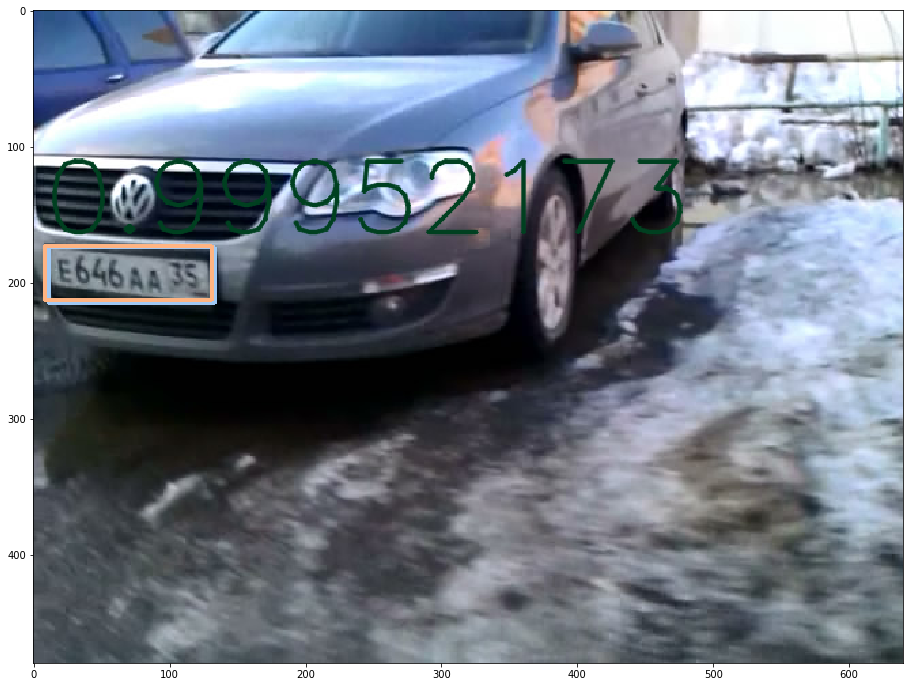

In [32]:
idx += 1
print(idx)
visualize_prediction(val_dataset[idx], model, 0.8)

In [33]:
thresholds = [0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.98]
ious = []

for threshold in thresholds:
    mean_val_iou, val_ious = evaluate_iou(model, val_loader, threshold, None)
    ious.append(mean_val_iou)

batch: 100%|██████████| 500/500 [01:28<00:00,  5.86it/s]


In [34]:
pd.DataFrame({'threshold': thresholds, 'iou': ious})

threshold       iou
0       0.50  0.859988
1       0.70  0.875017
2       0.80  0.881584
3       0.85  0.885172
4       0.90  0.883716
5       0.95  0.874026
6       0.98  0.860973

In [43]:
mean_val_iou, val_ious = evaluate_iou(model, val_loader, 0.85, None)

batch: 100%|██████████| 500/500 [01:39<00:00,  5.49it/s]


In [44]:
mean_val_iou

0.8851724431193867

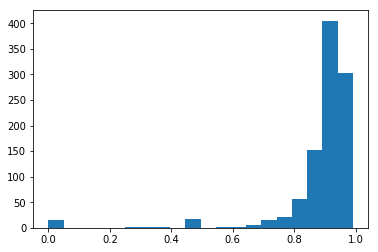

In [45]:
plt.hist(val_ious, bins=20);

In [46]:
err_indices = np.where(val_ious < 0.75)[0]
err_indices

array([ 27,  40,  46,  47,  57,  92,  98, 134, 151, 175, 176, 197, 212,
       244, 249, 256, 306, 316, 317, 344, 362, 379, 385, 393, 400, 407,
       413, 436, 437, 441, 452, 489, 500, 507, 512, 530, 540, 560, 598,
       600, 608, 614, 632, 662, 681, 752, 760, 780, 782, 813, 821, 827,
       833, 857, 881, 887, 911, 917, 931, 935, 952, 961, 977])

In [56]:
i = -1

Val sample #500	IoU=0.0000
Ground truth boxes count: 1
Predicted boxes count: 2


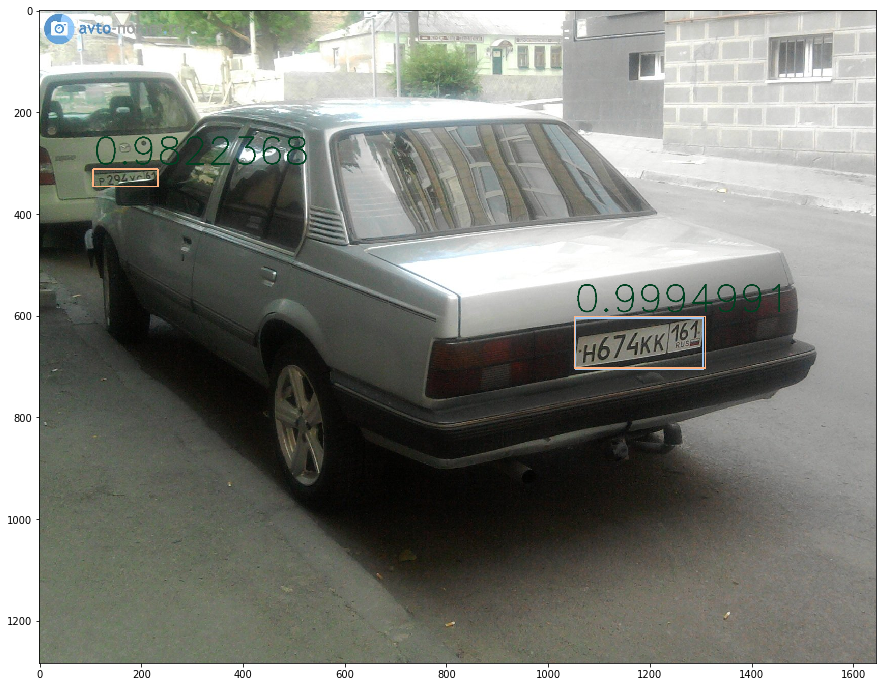

In [89]:
i += 1
idx = err_indices[i]
print(f'Val sample #{idx}\tIoU={val_ious[idx]:.4f}')
visualize_prediction(val_dataset[idx], model, 0.85)

Ground truth boxes count: 1
Predicted boxes count: 2


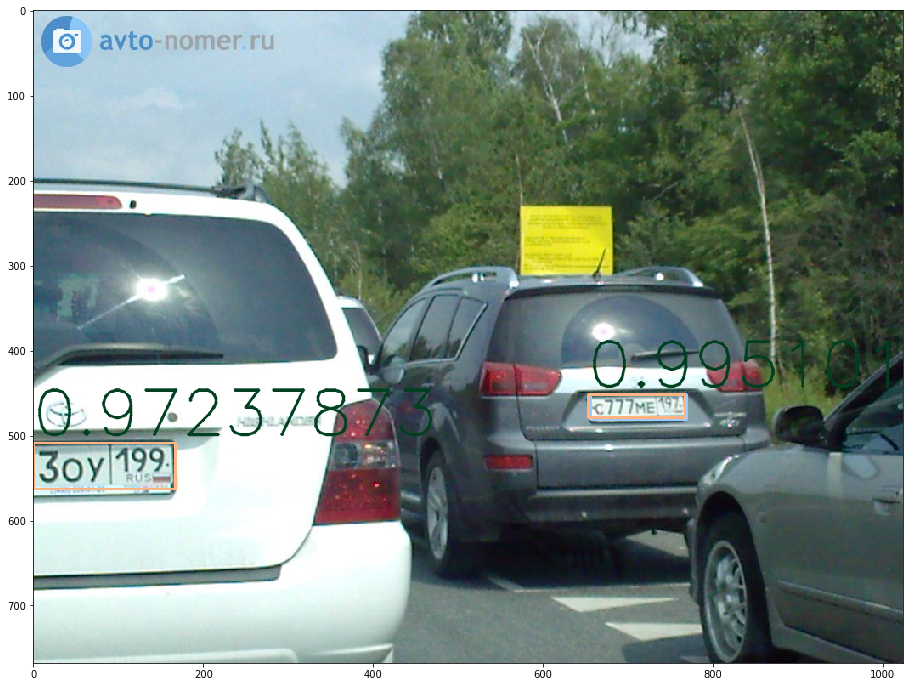

In [54]:
visualize_prediction(val_dataset[40], model, 0.95)

Ground truth boxes count: 1
Predicted boxes count: 1


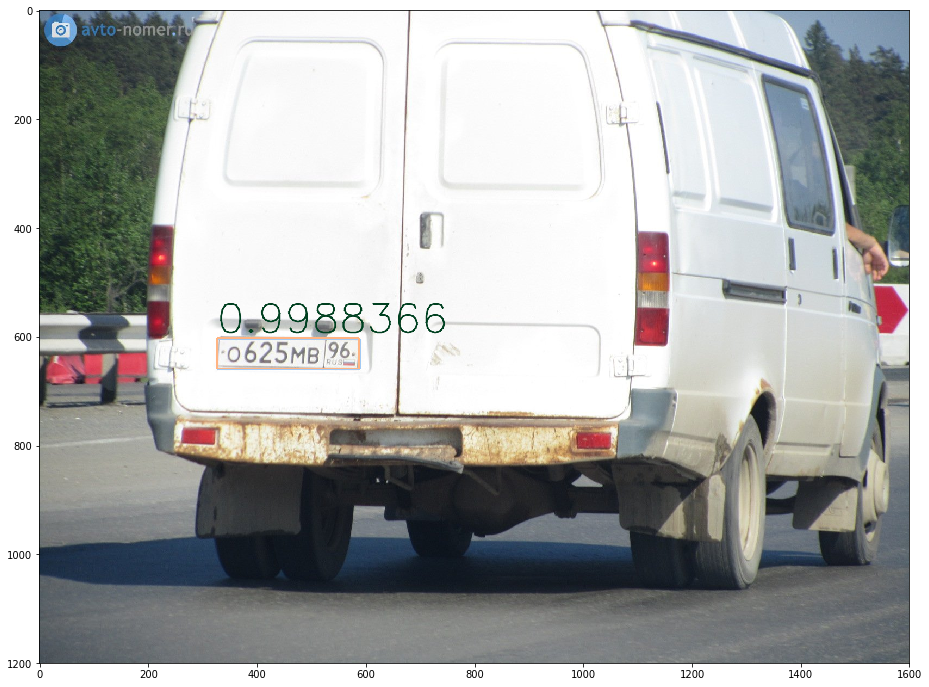

In [50]:
visualize_prediction(val_dataset[5], model, 0.95)